# Online Retail Sales Assessment

An e-commerce company aims to optimize its marketing and customer retention strategies. Currently, all customers receive the same promotions and communications, but the results are not optimal. To  improve campaign effectiveness, the company has decided to segment its customers into groups with similar characteristics and purchasing behaviors.

The **goal of this notebook** is to:

- Identify different customer segments based on purchase frequency, spending 
patterns, and transaction volume. 
- Analyze the characteristics of each segment to understand consumption patterns 
and specific needs. 

### Dataset description

The dataset to be analyzed contains online retail transactions from a UK-based online retailer. The dataset includes transactions from 2010 to 2011 and contains the following columns:

| Column       | Description                                                                                     | Data Type |
|--------------|-------------------------------------------------------------------------------------------------|-----------|
| `InvoiceNo`  | Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.       | Nominal   |
| `StockCode`  | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. | Nominal   |
| `Description`| Product (item) name. Nominal.                                                                   | Nominal   |
| `Quantity`   | The quantities of each product (item) per transaction. Numeric.                                 | Numeric   |
| `InvoiceDate`| Invoice Date and time. Numeric, the day and time when each transaction was generated.            | Numeric   |
| `UnitPrice`  | Unit price. Numeric, Product price per unit.                                                    | Numeric   |
| `CustomerID` | Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.          | Nominal   |
| `Country`    | Country name. Nominal, the name of the country where each customer resides.                      | Nominal   |



### Structure

1. Data Exploration
2. Missing values
3. Correlations analysis
4. Feature engineering (feature selection, feature transformation, feature creation, and evaluation)
5. Data transformations, such as normalization or standardization. 
6. Model comparison (K-means, Hierarchical clustering, DBSCAN)

### General Model Settings
The following cells contain some general settings for the notebook, mainly setting a standard aspect ratio for plots as well as setting a random seed for reproducibility.

In [1]:
# Set standard figure size to copy plots to presentation
fs = (15, 7)
fs_square = (10, 8)

# Set random seed

seed = 25

# Loading initial libraries - all libraries can be found in the requirements.txt file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Exploration

Load dataset and check the first rows of the data.

In [2]:
## Load data only if it doesn't exist in the enviroment already to save time

try:
    df_full #type: ignore
    print('Data already loaded, to reload full dataframe restart the kernel')
except NameError:
    df_full = pd.read_excel('DATA/Online Retail.xlsx')
    print('Data loaded')

Data loaded


In [3]:
df = df_full.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From this we see that:
-  The total dataset has 541909 rows and only 8 columns.
- `CustomerID` is a float, but it should be an integer.
- `Description` has some missing values
- `InvoiceDate` is already a DataTime object
- `CustomerID` has a lot of missing values which need to be cleaned up later on.

### Customer count per country

In [5]:
# Customer count per top 20 countries

country_df = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False) / len(df['CustomerID'].unique()) * 100
display(country_df.reset_index().head(20))

,Country,CustomerID
0,United Kingdom,90.327007
1,Germany,2.172422
2,France,1.989481
3,Spain,0.708895
4,Belgium,0.571690
5,Switzerland,0.480220
6,Portugal,0.434484
7,Italy,0.343014
8,Finland,0.274411
9,Austria,0.251544


The dataset is heavily skewed towards the UK with only very few customers from other countries. This is important to keep in mind when analyzing the data, as it may affect the results of the clustering algorithms.

# 2. Missing / faulty values

In [6]:
missing = df.isna().sum()
missing.sort_values(ascending=False, inplace=True)

display(missing)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

CustomerID seems to have a lot of missing values, so we need to go deeper into this.

In [7]:

# Check which customers are missing by country

missing_cust = df[df['CustomerID'].isna()]['Country'].value_counts()
missing_cust.sort_values(ascending=False, inplace=True)
display(missing_cust.reset_index().head(20))

,Country,count
0,United Kingdom,133600
1,EIRE,711
2,Hong Kong,288
3,Unspecified,202
4,Switzerland,125
5,France,66
6,Israel,47
7,Portugal,39
8,Bahrain,2


Here, we also check for negative quantities and prices:

In [8]:
negative_quantity_pct = (df['Quantity'] < 0).mean() * 100
print(f"Percentage of rows with negative Quantity: {negative_quantity_pct:.2f}%")

len(df[df['UnitPrice'] < 0])

Percentage of rows with negative Quantity: 1.96%


2

**Key Takeaways:**
- Quantity has around 2% of negative values, which might be returns or an error
- UnitPrice has only 2 negative values, so we can safely consider them as error

Both will be removed in the next step

### Initial cleaning and imputation

1) **Impute missing customer IDs** with a placeholder value and convert to integer: 
For transactions without CustomerID we treat each invoice as a separate "customer", extract the invoices without CustomerID and create a synthetic CustomerID for these before adding them back to the main dataset for now;   

For the clustering later we will **exclude** them to only work on the **real, identified customers.**

In [9]:
# First, extract invoices without CustomerID
invoices_without_customer = df[df['CustomerID'].isna()].copy()

# Create synthetic CustomerIDs based on invoice numbers for these transactions
invoices_without_customer['CustomerID'] = invoices_without_customer['InvoiceNo'].astype(str) + '_anon'

# Clean the CustomerID column to ensure it only contains valid integer-like values
df_with_customer = df.dropna(subset=['CustomerID']).copy()
df_with_customer['CustomerID'] = df_with_customer['CustomerID'].astype(str).str.split('.').str[0] 

# Combine with transactions that have real CustomerIDs
df = pd.concat([
	df_with_customer,
	invoices_without_customer
])

print(df[df['CustomerID'].astype(str).str.endswith('_anon')].shape[0], 'synthetic customer IDs created')

135080 synthetic customer IDs created


2. Fill missing descriptions with "Unknown Item"

> Note: Another, more sophisticated approach would be to check for existing StockCode - Description combinations and impute descriptions based on pre-existing StockCodes. Since Descriptions will not be used for clustering, we will not do this here.


In [10]:
df['Description'] = df['Description'].fillna('Unknown Item')

3. Remove returns (negative order quantity) and rows with negative or null unit prices

In [11]:
df = df[(df['UnitPrice'] > 0) & (df['UnitPrice'] != 0)]

df = df[(df['Quantity'] > 0) & (df['Quantity'] != 0)]

4. Check for Duplicates

Here we set which columns to check for duplicates. In this case, we will check for duplicates for. If all of `duplicate_cols` are the same, we consider it a duplicate. We will keep the first occurrence and drop the rest. As outcome we remove 5226 duplicate rows (0.96% of the dataset) which we assume to be a booking error.

In [12]:
# Check and drop duplicates
duplicate_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']

if duplicate_cols[3] not in duplicate_cols:
    print(f"Column {duplicate_cols[3]} not found in DataFrame. Please check the column names.")
else:
    print(f"Column {duplicate_cols[3]} found in DataFrame. Proceeding with duplicate check.")
    duplicates = df.duplicated(subset=duplicate_cols, keep='first')
    duplicates_count = duplicates.sum()
    print(f"Number of duplicate rows: {duplicates_count}")

df = df[~duplicates]
len(df)

Column Quantity found in DataFrame. Proceeding with duplicate check.
Number of duplicate rows: 5226


524878

### Outlier Analysis & Removal

For the outlier analysis we will use the total amount, meaning that either the quantity or the unit price can be outliers.

In [13]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,524878.0,10.6166,1.0,1.0,4.0,11.0,80995.0,156.280031
InvoiceDate,524878,2011-07-04 15:30:16.317048320,2010-12-01 08:26:00,2011-03-28 12:13:00,2011-07-20 11:22:00,2011-10-19 11:41:00,2011-12-09 12:50:00,NaN
UnitPrice,524878.0,3.922573,0.001,1.25,2.08,4.13,13541.33,36.093028
TotalAmount,524878.0,20.275399,0.001,3.9,9.92,17.7,168469.6,271.693566


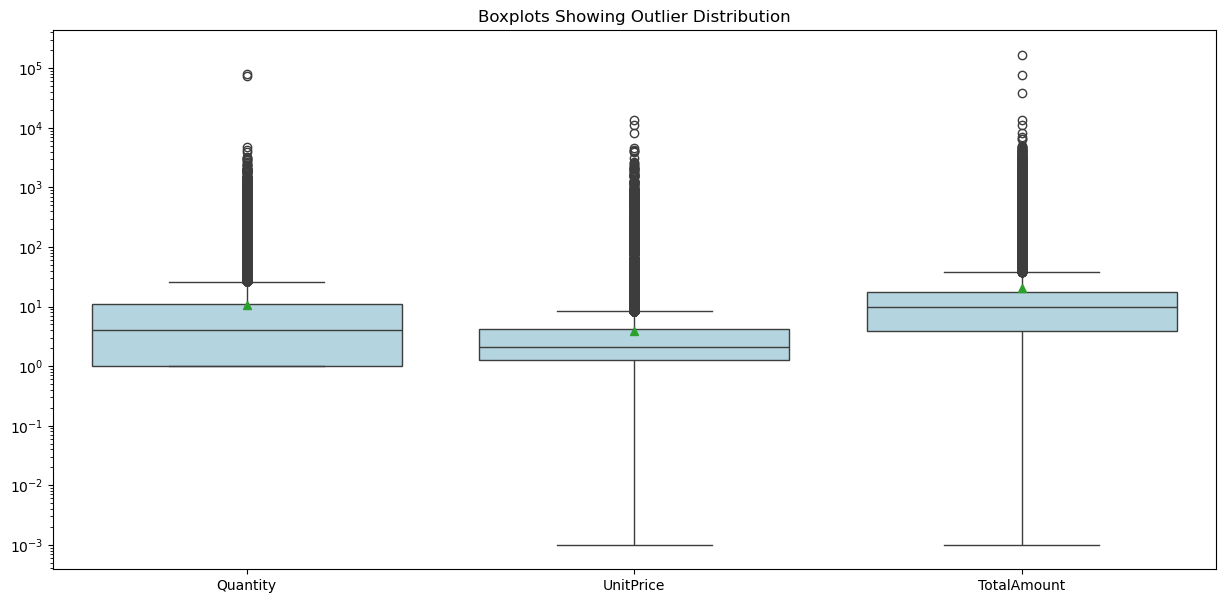

In [14]:
cols = ['Quantity', 'UnitPrice', 'TotalAmount']

# Boxplots to visualize outliers
plt.figure(figsize=fs)
sns.boxplot(data=df[cols], color='lightblue', showfliers=True, showmeans=True)
plt.title('Boxplots Showing Outlier Distribution')
plt.yscale('log')  # a log scale is used to better visualize the outliers
plt.show()

From the boxplot we already see that the total amounts are heavily skewed with some significant outliers or at least very high values. In this next section we are diving deeper into the visualization to consider removing or scaling the values.

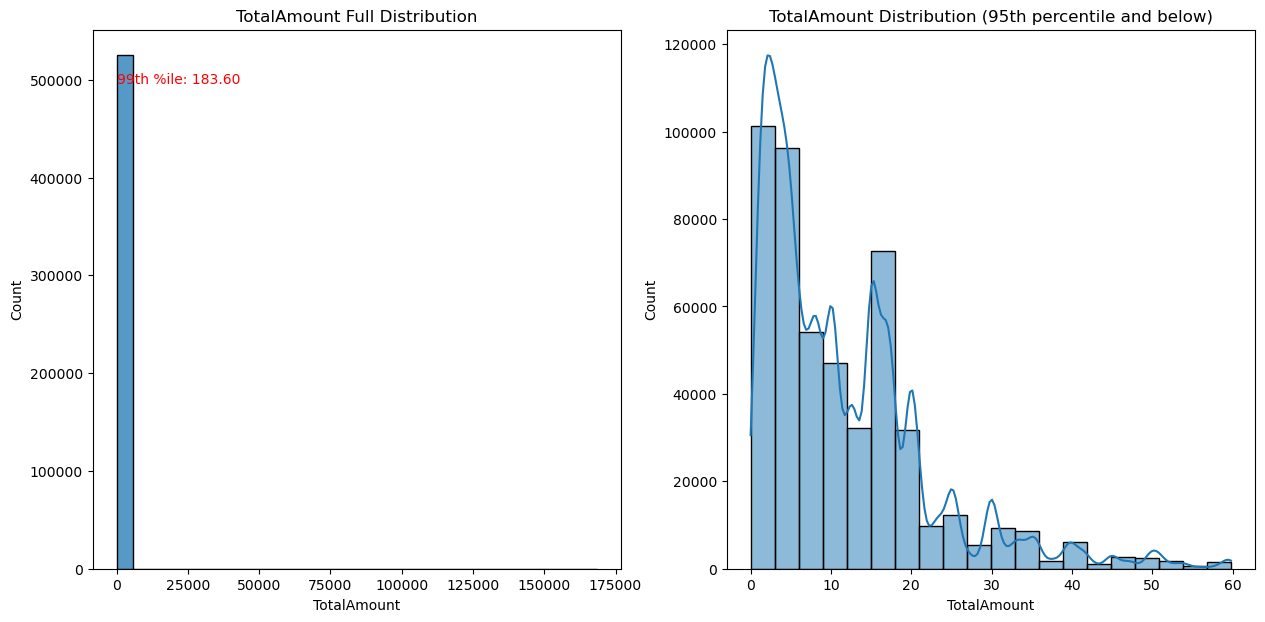


Summary for TotalAmount:
Mean: 20.28
Median: 9.92
Min: 0.00
Max: 168469.60
95th percentile: 59.80
99th percentile: 183.60
% of data above 99th percentile: 1.00%


In [15]:
col = 'TotalAmount'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fs)

# Original distribution
sns.histplot(data=df, x=col, bins=30, ax=ax1)
ax1.set_title(f'{col} Full Distribution')

# Add 99 percentile lines

pct_val = df[col].quantile(0.99)
ax1.text(pct_val, ax1.get_ylim()[1]*0.9, f'99th %ile: {pct_val:.2f}', color='r')

# Zoomed distribution (without extreme outliers)
upper_limit = df[col].quantile(0.95)
sns.histplot(data=df[df[col] <= upper_limit], x=col, bins=20, ax=ax2, kde=True)
ax2.set_title(f'{col} Distribution (95th percentile and below)')

plt.show()

# Print summary statistics
print(f"\nSummary for {col}:")
print(f"Mean: {df[col].mean():.2f}")
print(f"Median: {df[col].median():.2f}")
print(f"Min: {df[col].min():.2f}")
print(f"Max: {df[col].max():.2f}")
print(f"95th percentile: {df[col].quantile(0.95):.2f}")
print(f"99th percentile: {df[col].quantile(0.99):.2f}")
print(f"% of data above 99th percentile: {(df[col] > df[col].quantile(0.99)).mean()*100:.2f}%")

#### Examine the top 10 highest outliers

In [16]:
for col in cols:
    print(f"\nTop 10 highest {col} values:")
    outliers_high = df.sort_values(by=col, ascending=False).head(10)
    display(outliers_high[['CustomerID', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount']])


Top 10 highest Quantity values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,TotalAmount
540421,16446,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60
61619,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60
421632,12901,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,0.21,1008.00
206121,13135,554868,22197,SMALL POPCORN HOLDER,4300,0.72,3096.00
97432,18087,544612,22053,EMPIRE DESIGN ROSETTE,3906,0.82,3202.92
270885,14609,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,0.06,191.16
160546,15749,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
52711,15749,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
433788,16308,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,0.32,960.00
4945,16754,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,0.18,518.40



Top 10 highest UnitPrice values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,TotalAmount
15017,537632_anon,537632,AMAZONFEE,AMAZON FEE,1,13541.33,13541.33
299982,A563185_anon,A563185,B,Adjust bad debt,1,11062.06,11062.06
173382,16029,551697,POST,POSTAGE,1,8142.75,8142.75
297723,562955_anon,562955,DOT,DOTCOM POSTAGE,1,4505.17,4505.17
268028,560373_anon,560373,M,Manual,1,4287.63,4287.63
422351,12536,573077,M,Manual,1,4161.06,4161.06
422376,12536,573080,M,Manual,1,4161.06,4161.06
406406,12744,571751,M,Manual,1,3949.32,3949.32
374542,15502,569382,M,Manual,1,3155.95,3155.95
347948,567353_anon,567353,M,Manual,1,2653.95,2653.95



Top 10 highest TotalAmount values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,TotalAmount
540421,16446,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60
61619,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60
222680,15098,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,649.50,38970.00
15017,537632_anon,537632,AMAZONFEE,AMAZON FEE,1,13541.33,13541.33
299982,A563185_anon,A563185,B,Adjust bad debt,1,11062.06,11062.06
173382,16029,551697,POST,POSTAGE,1,8142.75,8142.75
348325,17450,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,5.06,7144.72
52711,15749,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
160546,15749,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
421601,14646,573003,23084,RABBIT NIGHT LIGHT,2400,2.08,4992.00


Especially regarding quantity there are two very high outliers at a factor 20x to the next highest value. Only those two values will be removes.

For the unit price, there are also two very high outliers, which don't make sense since they are an "Amazon Fee" and a bad debt adjustments; Both rather seem like an accounting misbooking and thus have to be removed; The **DOTCOM POSTAGE** also seems a bit weird, so this is the last deep-dive we will do.

In [17]:
df = df[~df['InvoiceNo'].isin([581483, 541431])]

Invoice No. 556444 has an error since the set consists of 60 pieces (Quantity should be 1), but the quanity is set to 60, which inflates the total amount. We will correct the quantity to 1

In [18]:
# Set quantity value for invoice 556444

df.loc[df['InvoiceNo'] == 556444, 'Quantity'] = 1

Products will the StockCode `DOT` will also be removed since they are postage articles

In [19]:
df[df['StockCode'] == 'DOT'].value_counts()

InvoiceNo  StockCode  Description     Quantity  InvoiceDate          UnitPrice  CustomerID   Country         TotalAmount
536544     DOT        DOTCOM POSTAGE  1         2010-12-01 14:32:00  569.77     536544_anon  United Kingdom  569.77         1
562955     DOT        DOTCOM POSTAGE  1         2011-08-11 10:14:00  4505.17    562955_anon  United Kingdom  4505.17        1
559491     DOT        DOTCOM POSTAGE  1         2011-07-08 13:53:00  164.54     559491_anon  United Kingdom  164.54         1
559492     DOT        DOTCOM POSTAGE  1         2011-07-08 13:53:00  56.04      559492_anon  United Kingdom  56.04          1
559493     DOT        DOTCOM POSTAGE  1         2011-07-08 13:53:00  166.96     559493_anon  United Kingdom  166.96         1
                                                                                                                           ..
548514     DOT        DOTCOM POSTAGE  1         2011-03-31 16:03:00  282.88     548514_anon  United Kingdom  282.88        

In [20]:
df[df['StockCode'] == 'M'].value_counts()

InvoiceNo  StockCode  Description  Quantity  InvoiceDate          UnitPrice  CustomerID   Country         TotalAmount
536569     M          Manual       1         2010-12-01 15:35:00  1.25       16274        United Kingdom  1.25           1
567353     M          Manual       1         2011-09-19 16:14:00  2653.95    567353_anon  Hong Kong       2653.95        1
567866     M          Manual       5         2011-09-22 14:13:00  0.80       16669        United Kingdom  4.00           1
567485     M          Manual       60        2011-09-20 13:52:00  0.08       15026        United Kingdom  4.80           1
567462     M          Manual       60        2011-09-20 12:35:00  0.08       14446        United Kingdom  4.80           1
                                                                                                                        ..
549739     M          Manual       1         2011-04-12 09:35:00  308.82     15935        United Kingdom  308.82         1
549730     M         

Since the `DOT` sales seem to be postage-related and thus not a true product sale and a manual stock code `M` has no information about the actual product itself, we will remove these rows.

In [21]:
print("Number of rows with StockCode 'M':", df[df['StockCode'] == 'M'].shape[0])
print("Number of rows with StockCode 'DOT':", df[df['StockCode'] == 'DOT'].shape[0])
print("Number of rows with StockCode 'POST':", df[df['StockCode'] == 'POST'].shape[0])
# Drop rows with StockCode 'DOT', 'M', and 'POST'
df = df[~df['StockCode'].isin(['DOT', 'M', 'POST'])]

Number of rows with StockCode 'M': 316
Number of rows with StockCode 'DOT': 706
Number of rows with StockCode 'POST': 1126


#### Examine the top 10 lowest outliers

In [22]:
for col in cols:
    print(f"\nTop 10 lowest {col} values:")
    outliers_low = df.sort_values(by=col, ascending=True).head(10)
    display(outliers_low[['CustomerID', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']])


Top 10 lowest Quantity values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice
541539,581498_anon,581498,85174,S/4 CACTI CANDLES,1,10.79
234696,15507,557595,22427,ENAMEL FLOWER JUG CREAM,1,5.95
234700,15507,557595,22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,2.95
234701,15507,557595,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,1,3.75
234703,15507,557595,20750,RED RETROSPOT MINI CASES,1,7.95
234708,15507,557595,22911,PAPER CHAIN KIT LONDON,1,2.95
234711,15507,557595,21363,HOME SMALL WOOD LETTERS,1,4.95
127839,547248_anon,547248,22858,EASTER TIN KEEPSAKE,1,3.29
127838,547248_anon,547248,22856,ASSORTED EASTER DECORATIONS BELLS,1,15.79
127837,547248_anon,547248,22835,HOT WATER BOTTLE I AM SO POORLY,1,9.13



Top 10 lowest UnitPrice values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice
361741,13405,568375,BANK CHARGES,Bank Charges,1,0.001
359871,16198,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
279045,15618,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
157195,13952,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
427789,13949,573399,16045,POPART WOODEN PENCILS ASST,100,0.040
221726,13694,556267,16045,POPART WOODEN PENCILS ASST,500,0.040
266551,13654,560259,16045,POPART WOODEN PENCILS ASST,100,0.040
302639,13189,563440,16045,POPART WOODEN PENCILS ASST,100,0.040
402329,13265,571496,16045,POPART WOODEN PENCILS ASST,100,0.040
217060,15799,555876,16045,POPART WOODEN PENCILS ASST,100,0.040



Top 10 lowest TotalAmount values:


,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice
359871,16198,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
157195,13952,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
279045,15618,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,0.001
361741,13405,568375,BANK CHARGES,Bank Charges,1,0.001
500313,12748,578757,16216,LETTER SHAPE PENCIL SHARPENER,1,0.060
423991,573174_anon,573174,16218,CARTOON PENCIL SHARPENERS,1,0.060
257038,15920,559509,17038,PORCELAIN BUDAH INCENSE HOLDER,1,0.100
241349,14104,558198,17038,PORCELAIN BUDAH INCENSE HOLDER,1,0.100
497822,15858,578479,17038,PORCELAIN BUDAH INCENSE HOLDER,1,0.100
386534,16332,570238,16048,TEATIME ROUND PENCIL SHARPENER,1,0.120


In [23]:
num_pads = len(df[df['StockCode'] == 'PADS'])
num_bank_charges = len(df[df['StockCode'] == 'BANK CHARGES'])

print(f'There are {num_pads} pads in the dataset with a total of {df[df["StockCode"] == "PADS"]["Quantity"].sum()} units sold.')
print(f'There are {num_bank_charges} bank charges in the dataset with a total of {df[df["StockCode"] == "BANK CHARGES"]["Quantity"].sum()} units sold.')

There are 3 pads in the dataset with a total of 3 units sold.
There are 12 bank charges in the dataset with a total of 12 units sold.


Since both `PADS` and the bank charges do not seem like actual products, plus appear only once we remove them:

In [24]:
df = df[~df['StockCode'].isin(["PADS", "BANK CHARGES"])]

# 3. Feature engineering

## Remove anonymized customers
We will remove the anonymized customers from the dataset, since they are not relevant for our analysis.

In [25]:
print("DataFrame before dropping CustomerIDs")
print(df[['StockCode','CustomerID', 'Country', 'InvoiceNo']].nunique())
real_customers = df[~df['CustomerID'].str.endswith('_anon')]['CustomerID'].nunique()
print(f"Number of real customers: {real_customers}")

print(f'Full dataframe shape: {df_full.shape}')

df = df[~df['CustomerID'].str.endswith('_anon')]
print(f'Cleaned dataframe shape: {df.shape}')
print("DataFrame after dropping CustomerIDs")
print(df[['StockCode','CustomerID', 'Country', 'InvoiceNo']].nunique())

DataFrame before dropping CustomerIDs
StockCode      3916
CustomerID     5709
Country          38
InvoiceNo     19779
dtype: int64
Number of real customers: 4333
Full dataframe shape: (541909, 8)
Cleaned dataframe shape: (391281, 9)
DataFrame after dropping CustomerIDs
StockCode      3659
CustomerID     4333
Country          37
InvoiceNo     18403
dtype: int64


## Create New Features

**RFM Core Metrics**

- **Recency:**  
  Recent customers are more likely to purchase again. By measuring the time since their last purchase, we can identify which customers are still active and target those who might be at risk of churning.

- **Frequency:**  
  Repeated purchasing is a strong indicator of loyalty. Tracking how often a customer makes a purchase helps us recognize our regular buyers and reward their commitment.

- **Monetary:**  
  High spenders are typically our most valuable customers. By summing the total spend per customer, we can focus on those who generate the highest revenue and tailor premium services or offers to them.

**Other Basket Metrics**

- **AvgBasketSize:**  
  This feature helps distinguish bulk buyers from small purchasers. Customers with larger basket sizes might be more interested in deals on quantity or might have different product preferences compared to those who purchase less per transaction.

- **DistinctItems:**  
  Tracking the number of unique products purchased helps us understand customer diversity. Customers buying a variety of items might have broader interests, while those focused on a few products may indicate a niche preference that can be catered to.

**Seasonality Metrics**

- **MonthsActive:**  
  The number of distinct months in which a customer made purchases indicates their engagement over time. This helps distinguish between long-term customers and those who may be seasonal or sporadic.

- **PurchaseConsistency:**  
  The ratio between frequency and months active reveals how regularly customers make purchases within their active months. Higher values indicate multiple purchases in the same months, suggesting more engaged customers.

- **PurchaseCoverage:**  
  What percentage of all available months did the customer make purchases in? This metric helps identify truly consistent buyers versus those who shop only during specific periods.

**Geographic Segmentation**

- **IsUK:**  
  Since around 90% of customers come from the UK, we use a binary flag to separate domestic customers from international ones. This distinction allows for region-specific analysis and targeted marketing strategies.

In [26]:
# First, create a reference date (last date in the dataset + 1 day)
last_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Extract the month from the InvoiceDate
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Extract the day of the week from the InvoiceDate
df['InvoiceDayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# Group by CustomerID to create customer-level features
customer_features = df.groupby('CustomerID').agg(
    # Recency - days since last purchase
    Recency=('InvoiceDate', lambda x: (last_date - x.max()).days),
    
    # Frequency - count of invoices (unique)
    Frequency=('InvoiceNo', lambda x: x.nunique()),
    
    # Monetary - total spend
    Monetary=('TotalAmount', 'sum'),
    
    # Alternative/Additional Features
    AvgBasketSize=('Quantity', 'mean'),  # Average items per order
    AvgBasketValue=('TotalAmount', 'mean'),  # Average order value
    DistinctItems=('StockCode', 'nunique'),  # Distinct items purchased 
    
    # Seasonality Features
    MonthsActive=('InvoiceMonth', 'nunique'),  # Number of unique months with purchases
    
    # Country
    Country=('Country', 'first')
).reset_index()

# Calculate purchase consistency (higher value = more consistent buyer)
customer_features['PurchaseConsistency'] = customer_features['Frequency'] / customer_features['MonthsActive']

# Determine time range of dataset in months(not used for clustering)
total_months_in_data = df['InvoiceMonth'].nunique()

# Add purchase coverage - what fraction of available months did the customer purchase in
customer_features['PurchaseCoverage'] = customer_features['MonthsActive'] / total_months_in_data

# Add UK flag
customer_features['IsUK'] = np.where(customer_features['Country'] == 'United Kingdom', 1, 0)

**Check for outliers in newly created total amount feature**

In [27]:
print(f"\nTop 10 highest total amount values:")
outliers_high = customer_features.sort_values(by='Monetary', ascending=False).head(10)
display(outliers_high)


Top 10 highest total amount values:


,CustomerID,Recency,Frequency,Monetary,AvgBasketSize,AvgBasketValue,DistinctItems,MonthsActive,Country,PurchaseConsistency,PurchaseCoverage,IsUK
1688,14646,2,72,279138.02,95.555340,135.503893,699,13,Netherlands,5.538462,1.000000,0
4196,18102,1,60,259657.30,148.779582,602.453132,150,12,United Kingdom,5.000000,0.923077,1
3724,17450,8,46,194390.79,208.252976,578.544018,124,12,United Kingdom,3.833333,0.923077,1
1878,14911,1,199,140336.83,14.156316,24.759497,1786,13,EIRE,15.307692,1.000000,0
54,12415,24,20,124564.53,108.517532,174.704811,443,10,Australia,2.000000,0.769231,0
1332,14156,10,55,117210.08,41.410753,84.021563,714,12,EIRE,4.583333,0.923077,0
3767,17511,3,31,91062.38,67.029076,94.561142,453,13,United Kingdom,2.384615,1.000000,1
2699,16029,39,62,72708.09,167.112500,302.950375,43,12,United Kingdom,5.166667,0.923077,1
3173,16684,4,28,66653.56,181.425993,240.626570,119,9,United Kingdom,3.111111,0.692308,1
995,13694,4,50,65039.62,111.464789,114.506373,366,13,United Kingdom,3.846154,1.000000,1


Based on this we see, that while the distribution is still skewed, the outliers are not as extreme as before. We will not remove any more outliers at this stage, but keep an eye on them in the clustering step and use a robust scaler to mitigate their effect on the clustering algorithms.

# 4. Correlation Analysis

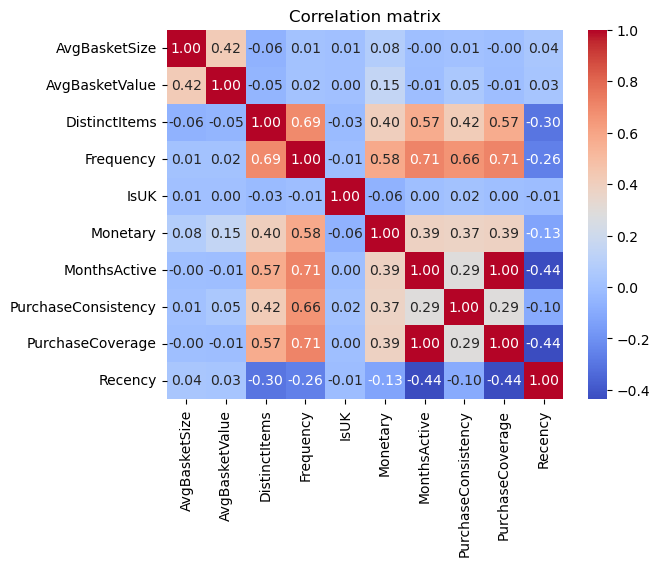

In [28]:
# Compute the correlation matrix
excluded_cols = ['CustomerID', 'Country']

#corr = df[df.columns.difference(excluded_cols)].corr()
corr = customer_features[customer_features.columns.difference(excluded_cols)].corr()


sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

### Correlation Matrix Analysis  

- **Log-Transformed Features:**  
  To address skewness and improve clustering performance, the following features arelog-transformed:  
  - *Monetary* → *Monetary_log*  
  - *AvgBasketSize* → *AvgBasketSize_log*  
  - *AvgBasketValue* → *AvgBasketValue_log*  
  - *Recency* → *Recency_log*  
  - *Frequency* → *Frequency_log*  
  - *DistinctItems* → *DistinctItems_log*  

- **Feature Selection for Clustering:**  
  After log transformation, the following features were selected for clustering:  
  ✔ *Recency_log*  
  ✔ *Frequency_log*  
  ✔ *Monetary_log*  
  ✔ *AvgBasketSize_log*  
  ✔ *AvgBasketValue_log*  
  ✔ *DistinctItems_log*  
  ✔ *PurchaseConsistency*  
  ✔ *PurchaseCoverage*  
  ✔ *IsUK*  


In [29]:
#cluster_cols = ['Recency', 'Frequency', 'Monetary_log', 'AvgBasketSize_log', 'AvgBasketValue_log', 'DistinctItems', 'PurchaseConsistency', 'PurchaseCoverage', 'IsUK']
cluster_cols = ['Recency_log', 'Frequency_log', 'Monetary_log', 'AvgBasketSize_log', 'AvgBasketValue_log', 'DistinctItems_log', 'PurchaseConsistency', 'PurchaseCoverage', 'IsUK']

# 5. Data transformations

In [30]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           4333 non-null   object 
 1   Recency              4333 non-null   int64  
 2   Frequency            4333 non-null   int64  
 3   Monetary             4333 non-null   float64
 4   AvgBasketSize        4333 non-null   float64
 5   AvgBasketValue       4333 non-null   float64
 6   DistinctItems        4333 non-null   int64  
 7   MonthsActive         4333 non-null   int64  
 8   Country              4333 non-null   object 
 9   PurchaseConsistency  4333 non-null   float64
 10  PurchaseCoverage     4333 non-null   float64
 11  IsUK                 4333 non-null   int32  
dtypes: float64(5), int32(1), int64(4), object(2)
memory usage: 389.4+ KB


### Log Transformation

In [31]:
customer_features_transformed = customer_features.copy()

log_cols = ['Monetary', 'AvgBasketSize', 'AvgBasketValue', 'Recency', 'Frequency', 'DistinctItems']

for col in log_cols:
    customer_features_transformed[col + '_log'] = np.log1p(customer_features_transformed[col])

customer_features_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4333.0,92.696515,100.130990,1.000000,18.000000,51.000000,143.000000,374.000000
Frequency,4333.0,4.247173,7.643341,1.000000,1.000000,2.000000,5.000000,206.000000
Monetary,4333.0,1961.287893,8478.728934,2.900000,304.250000,661.520000,1628.560000,279138.020000
AvgBasketSize,4333.0,22.336036,120.119616,1.000000,6.043478,10.000000,14.706897,4300.000000
AvgBasketValue,4333.0,37.236271,240.526107,1.450000,12.256667,17.568000,24.627059,13305.500000
DistinctItems,4333.0,61.446573,85.318001,1.000000,16.000000,35.000000,77.000000,1786.000000
MonthsActive,4333.0,3.005077,2.626042,1.000000,1.000000,2.000000,4.000000,13.000000
PurchaseConsistency,4333.0,1.219805,0.760018,1.000000,1.000000,1.000000,1.250000,34.000000
PurchaseCoverage,4333.0,0.231160,0.202003,0.076923,0.076923,0.153846,0.307692,1.000000
IsUK,4333.0,0.903531,0.295267,0.000000,1.000000,1.000000,1.000000,1.000000


### Histogram of all features

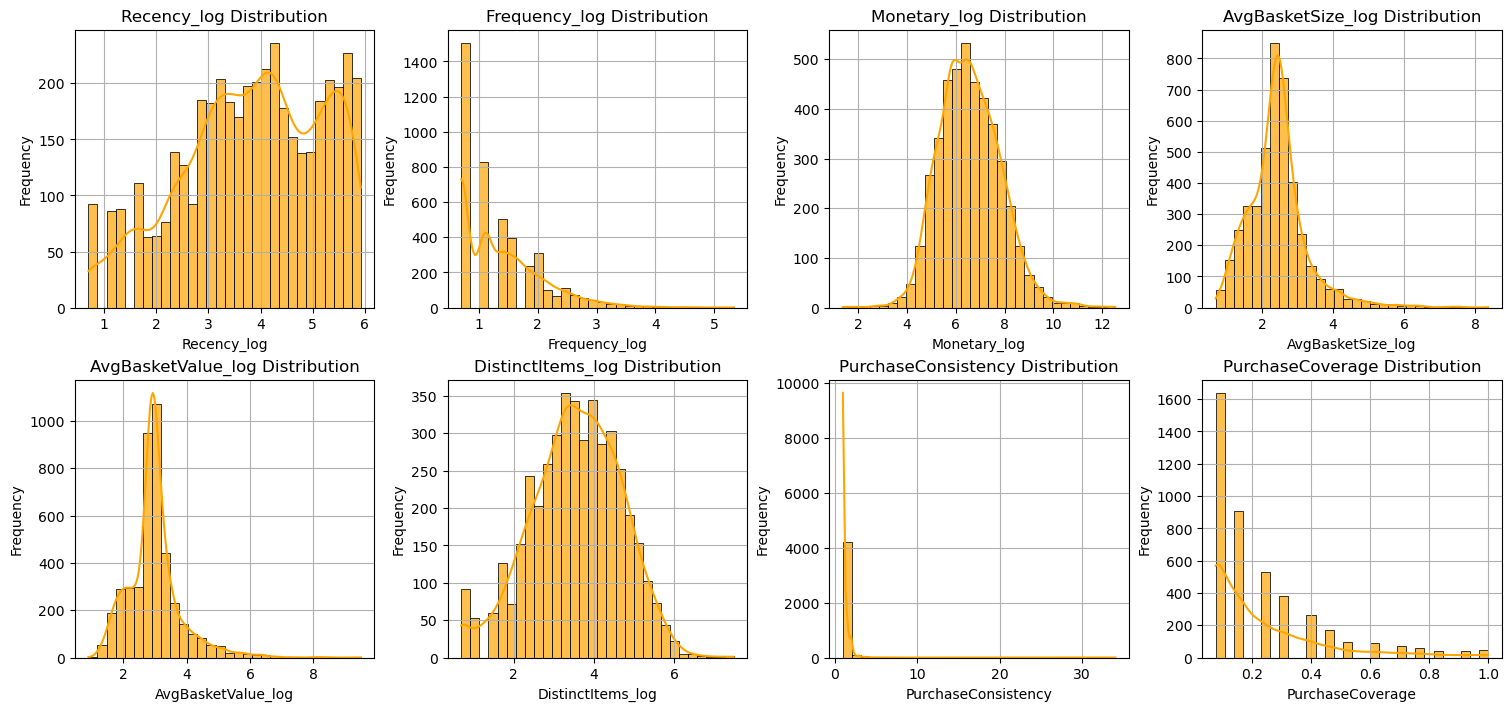

In [32]:
## Create histogram plots for the transformed features in one plot

# Create histogram plots for the transformed features in a grid layout
fig, axes = plt.subplots(2, 4, figsize=fs, constrained_layout=True)

for ax, col in zip(axes.flatten(), cluster_cols):
    sns.histplot(customer_features_transformed[col], bins=30, color = 'orange', kde=True, ax=ax, alpha=0.7)
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Remove any unused subplot axes
for ax in axes.flatten()[len(cluster_cols):]:
    fig.delaxes(ax)

plt.show()

### Feature Scaling

To scale the partially still skewed features, we will use a **RobustScaler**. This is particularly useful for our dataset because:

- Instead of using mean and standard deviation, robust scaling uses the median and interquartile range (IQR), making it less influenced by extreme values.

- Our retail dataset has several outliers in monetary values and purchase quantities. Regular standardization would be heavily impacted by these, distorting distances between normal data points.

- It maintains the relationships between values while reducing the impact of extreme customers (like those with unusually high spend or frequency).

Values are scaled as: `(X - median) / IQR`; This approach helps ensure our clustering results aren't dominated by a few abnormal customers, which would create misleading segments.

In [33]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = customer_features_transformed.copy()
X_scaled[cluster_cols] = scaler.fit_transform(customer_features_transformed[cluster_cols])

X_cluster = X_scaled.drop(['CustomerID', 'Country'] + log_cols, axis=1)
X_cluster.head(3)

,MonthsActive,PurchaseConsistency,PurchaseCoverage,IsUK,Monetary_log,AvgBasketSize_log,AvgBasketValue_log,Recency_log,Frequency_log,DistinctItems_log
0,7,0.0,1.666667,-1.0,1.118178,0.344929,0.431780,-1.408447,0.892789,0.696341
1,4,0.0,0.666667,-1.0,0.462779,2.583874,1.626061,0.187368,0.464974,-0.323254
2,1,0.0,-0.333333,-1.0,0.471151,-0.150409,0.204238,-0.471770,-0.369070,0.464025


# 6. Clustering Algorithm Comparison

In this section we are comparing the different clustering algorithms and their performance. 
* KMeans
* Hierarchical Clustering
* DBSCAN

## K-Means Clustering
### Determining the optimal number of clusters

for KMeans and Hierarchical Clustering we will use the **Elbow Method** combined with a **Silhouette Score** to determine the optimal number of clusters.

c:\Users\timos\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\timos\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\timos\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\timos\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\timos\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

Optimal number of clusters (k): 4


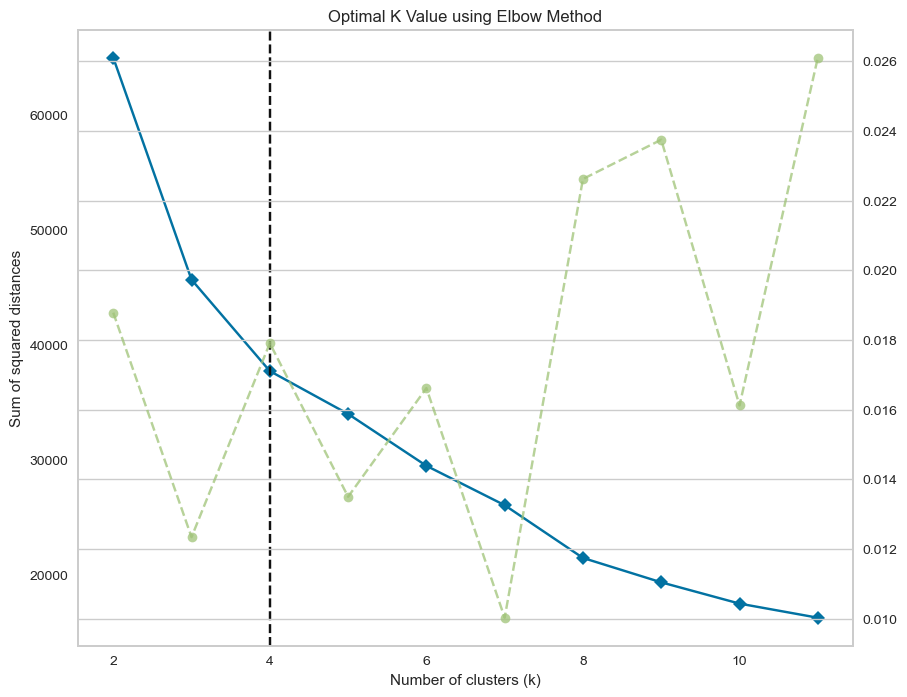

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

plt.figure(figsize=fs_square)

# Create and fit the visualizer
visualizer = KElbowVisualizer(KMeans(random_state= seed), k=(2, 12), LOKY_MAX_CPU_COUNT=4)
visualizer.fit(X_cluster)

visualizer.ax.set_title('Optimal K Value using Elbow Method')
visualizer.ax.set_xlabel('Number of clusters (k)')
visualizer.ax.set_ylabel('Sum of squared distances')
visualizer.ax.grid(False)

optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters (k): {optimal_k}")

plt.show()

For n_clusters = 2, the silhouette score is 0.517
For n_clusters = 3, the silhouette score is 0.479
For n_clusters = 4, the silhouette score is 0.344
For n_clusters = 5, the silhouette score is 0.259
For n_clusters = 6, the silhouette score is 0.265
For n_clusters = 7, the silhouette score is 0.248
For n_clusters = 8, the silhouette score is 0.320
For n_clusters = 9, the silhouette score is 0.319
For n_clusters = 10, the silhouette score is 0.282
For n_clusters = 11, the silhouette score is 0.268


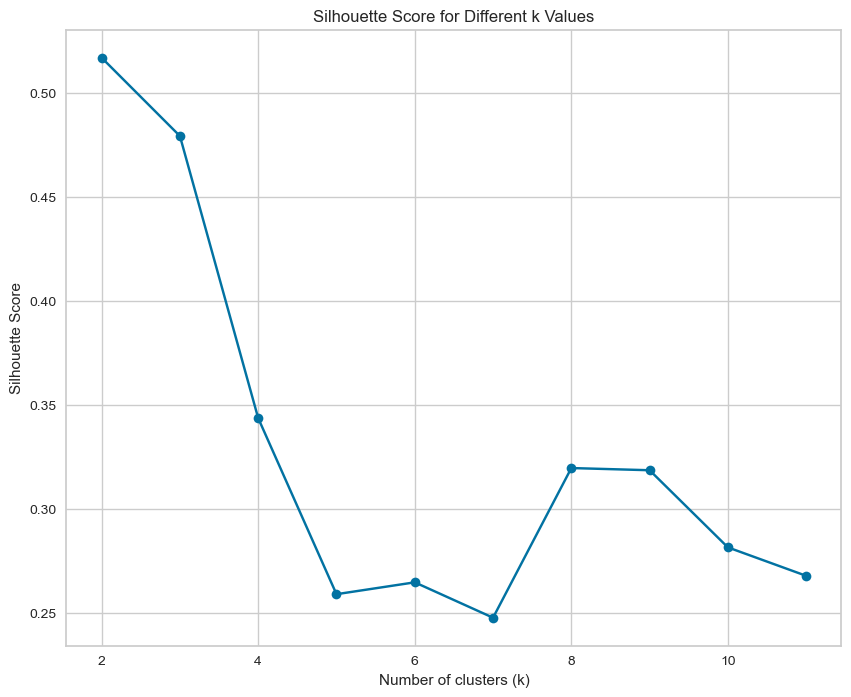

In [35]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_values = range(2, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state= seed)
    cluster_labels = kmeans.fit_predict(X_cluster)
    silhouette_avg = silhouette_score(X_cluster, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=fs_square)
plt.plot(k_values, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.show()

We finally apply the k-means clustering algorithm using the `optimal_k` value determined above. 

In [36]:
kmeans = KMeans(n_clusters=optimal_k, random_state= seed)

customer_features['kM_Cluster'] = kmeans.fit_predict(X_cluster)

# Check cluster sizes
cluster_sizes = customer_features['kM_Cluster'].value_counts()
print("Cluster sizes:")
print(cluster_sizes)

Cluster sizes:
kM_Cluster
3    2838
0    1179
1     313
2       3
Name: count, dtype: int64


## Hierarchical Clustering

Next, we run hierarchical clustering on the same dataset. We will use the same `optimal_k` value as for k-means to compare the results and plot the dendogram to visualize the clusters.

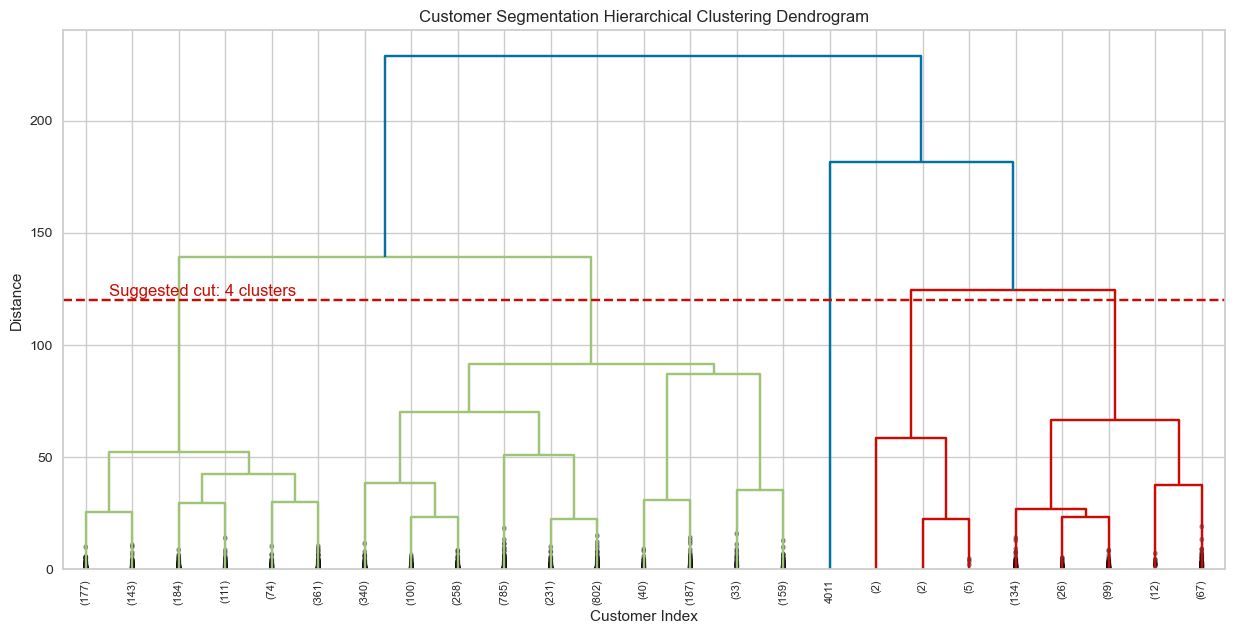

Silhouette Score for Hierarchical Clustering with 4 clusters: 0.300


In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

plt.figure(figsize=fs)

# Apply hierarchical clustering using Ward's method to minimizes variance within clusters
Z = linkage(X_cluster, method='ward')

## --- Display dendrogram --- ##
plt.title('Customer Segmentation Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')

if len(X_cluster) > 100:
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=25,  
        leaf_font_size=8,
        leaf_rotation=90,
        show_contracted=True 
    )
else:
    dendrogram(
        Z,
        leaf_font_size=10,
        leaf_rotation=90
    )

cut_height = 120
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.text(10, cut_height + 2, f'Suggested cut: {optimal_k} clusters', color='r')
plt.show()

hierarchical_labels = fcluster(Z, optimal_k, criterion='maxclust')
customer_features['Hierarchical_Cluster'] = hierarchical_labels

# Calculate silhouette score for the hierarchical clustering
silhouette_hierarchical = silhouette_score(X_cluster, hierarchical_labels)
print(f"Silhouette Score for Hierarchical Clustering with {optimal_k} clusters: {silhouette_hierarchical:.3f}")

The dendrogram above represents the hierarchical clustering of customers based on their purchasing behavior. 

- **Cluster Formation:** The vertical axis indicates the **distance (or dissimilarity)** between clusters. The higher the linkage, the more distinct the groups are.
- **Suggested Cut:** The red dashed line suggests the clustering cut at **4 clusters**.
- **Cluster Insights:**
  - Customers grouped in the same branch (e.g. red, green and purple) exhibit similar purchasing behaviors.
  - Larger vertical jumps indicate significant differences between clusters, meaning that merging them would increase intra-cluster variability.


We next compare this to the DBSCAN algorithm, which is a density-based clustering algorithm.

## DBSCAN Clustering

Here we apply the DBSCAN algorithm to the same dataset. DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.

- **Advantages:** It doesn't require specifying number of clusters, can find arbitrarily shaped clusters, naturally handles outliers
- **Disadvantages:** Sensitive to parameter selection, not suitable for high-dimensional data (which shouldn't apply in this case since we are using "only" 9 features).

Since DBSCAN is sensitive to parameter selection, we need to carefully choose the parameters `eps` (neighborhood radius) and `min_samples` (minimum number of points to form a dense region).
To achieve this we will experiment with different values for `eps` and `min_samples` to find the best clustering results as tradeoff between number of clusters and silhouette score and "filtered-out" noise.

### Determining the optimal epsilon value

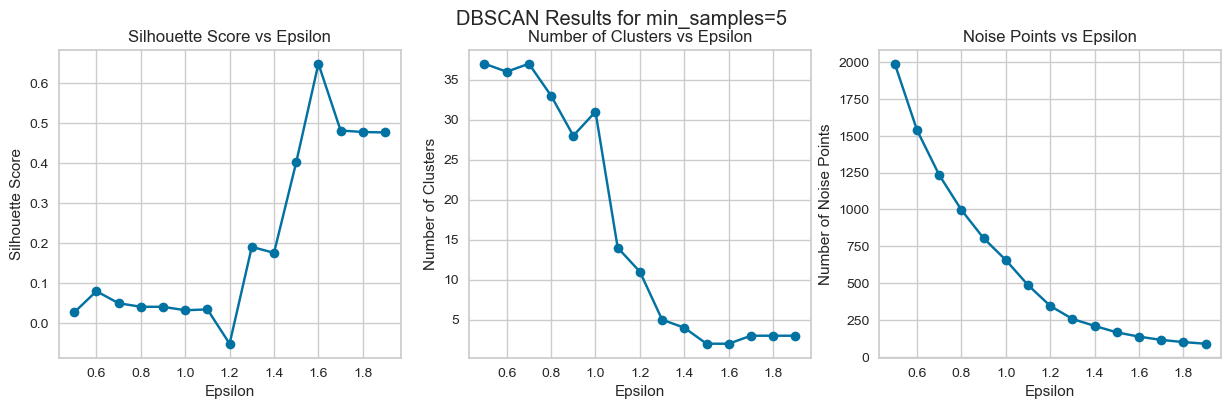

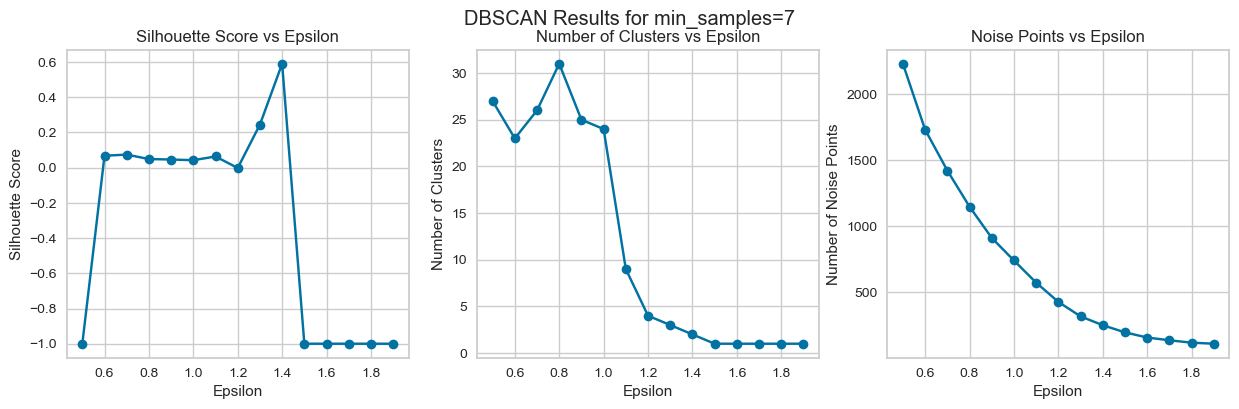

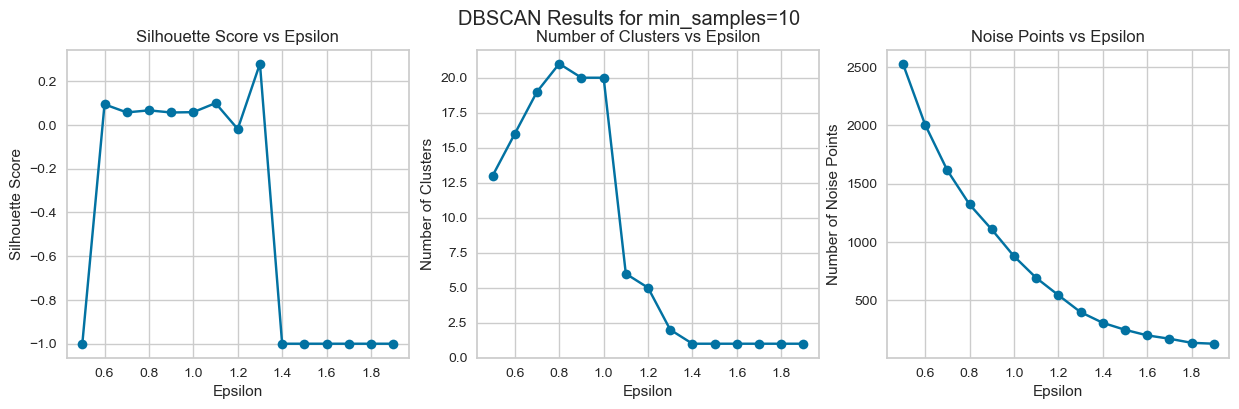


Best DBSCAN parameters:
Epsilon: 1.5999999999999996
Min Samples: 5.0
Number of clusters: 2.0
Noise points: 137.0 (3.161781675513501%)
Silhouette Score: 0.6480

Top 5 parameter combinations:


,min_samples,eps,n_clusters,n_noise,n_noise_pct,silhouette
11,5,1.6,2,137,3.161782,0.648038
24,7,1.4,2,252,5.815832,0.590729
12,5,1.7,3,115,2.654050,0.480925
13,5,1.8,3,100,2.307870,0.477262
14,5,1.9,3,89,2.054004,0.476079


In [38]:
from sklearn.cluster import DBSCAN

eps_values = np.arange(0.5, 2, 0.1)  # Range of epsilon values to test
min_samples = [5, 7, 10]  # Multiple min_samples values to test

results = []

for min_sample in min_samples:
    silhouette_scores = []
    n_clusters_list = []
    n_noise_list = []
    
    for eps in eps_values:
            
        # Fit DBSCAN with current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(X_cluster)
        
        # Count unique clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate silhouette score if we have valid clusters
        if n_clusters > 1 and n_noise < len(X_cluster) * 0.5:  # Avoid extreme cases
            try:
                # Only include non-noise points in silhouette calculation
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > n_clusters:  # Need more points than clusters
                    silhouette_avg = silhouette_score(
                        X_cluster[non_noise_mask], 
                        labels[non_noise_mask]
                    )
                else:
                    silhouette_avg = -1  # Invalid case
            except:
                silhouette_avg = -1  # Error case
        else:
            silhouette_avg = -1  # Invalid clustering
            
        silhouette_scores.append(silhouette_avg)
        n_clusters_list.append(n_clusters)
        n_noise_list.append(n_noise)
        
        # Store results
        results.append({
            'min_samples': min_sample,
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'n_noise_pct': n_noise / len(X_cluster) * 100,
            'silhouette': silhouette_avg
        })
        
    # Plot results for this min_samples value
    plt.figure(figsize= (15, 4))
    plt.suptitle(f'DBSCAN Results for min_samples={min_sample}')
    
    plt.subplot(1, 3, 1)
    plt.plot(eps_values[:len(silhouette_scores)], silhouette_scores, 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Epsilon')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(eps_values[:len(n_clusters_list)], n_clusters_list, 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Number of Clusters')
    plt.title('Number of Clusters vs Epsilon')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(eps_values[:len(n_noise_list)], n_noise_list, 'o-')
    plt.xlabel('Epsilon')
    plt.ylabel('Number of Noise Points')
    plt.title('Noise Points vs Epsilon')
    plt.grid(True)
    plt.show()

results_df = pd.DataFrame(results)
valid_results = results_df[results_df['silhouette'] > 0].copy()

# Find the best parameter combination based on silhouette score
if len(valid_results) > 0:
    best_params = valid_results.loc[valid_results['silhouette'].idxmax()]
    print("\nBest DBSCAN parameters:")
    print(f"Epsilon: {best_params['eps']}")
    print(f"Min Samples: {best_params['min_samples']}")
    print(f"Number of clusters: {best_params['n_clusters']}")
    print(f"Noise points: {best_params['n_noise']} ({best_params['n_noise_pct']}%)")
    print(f"Silhouette Score: {best_params['silhouette']:.4f}")
    
    # Show top 5 parameter combinations
    print("\nTop 5 parameter combinations:")
    display(valid_results.sort_values('silhouette', ascending=False).head())
else:
    print("No valid clustering configurations found.")

In [39]:
# Apply the optimal DBSCAN parameters
optimal_eps = best_params['eps']
optimal_min_samples = int(best_params['min_samples'])

# Run DBSCAN with optimal parameters
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
customer_features['DBSCAN_Cluster'] = dbscan_optimal.fit_predict(X_cluster)

# Calculate the percentage of noise points
noise_percentage = (customer_features['DBSCAN_Cluster'] == -1).mean() * 100
print(f"Percentage of noise points: {noise_percentage:.2f}%")

# Display the distribution of clusters
dbscan_cluster_counts = customer_features['DBSCAN_Cluster'].value_counts().sort_index()
print("\nDBSCAN cluster distribution:")
print(dbscan_cluster_counts)

Percentage of noise points: 3.16%

DBSCAN cluster distribution:
DBSCAN_Cluster
-1     137
 0    4191
 1       5
Name: count, dtype: int64


## Evaluation of Clustering Results

1. Defining analysis metrics (available information from customer features)
2. Comparing the different clustering methods


In [40]:
available_infos = customer_features.columns
print(f"There are {len(available_infos)} features available in the analysis dataset:")
print(available_infos)

There are 15 features available in the analysis dataset:
Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AvgBasketSize',
       'AvgBasketValue', 'DistinctItems', 'MonthsActive', 'Country',
       'PurchaseConsistency', 'PurchaseCoverage', 'IsUK', 'kM_Cluster',
       'Hierarchical_Cluster', 'DBSCAN_Cluster'],
      dtype='object')


Here we define the metrics and aggregation methods to analyze the clusters. We will use the following metrics to analyze the clusters:
- **Recency:** Mean of recency values
- **Frequency:** Mean of frequency values
- **Monetary:** Mean of monetary values
- **AvgBasketSize:** Mean of average basket size values
- **AvgBasketValue:** Mean of average basket value values
- **DistinctItems:** Mean of distinct items values
- **PurchaseConsistency:** Mean of purchase consistency values
- **PurchaseCoverage:** Mean of purchase coverage values
- **IsUK:** Percentage of customers from the UK
- **Cluster Size:** Number of customers in each cluster

In [41]:
info_dict = {
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AvgBasketSize': 'mean',
    'AvgBasketValue': 'mean',
    'DistinctItems': 'mean',
    'PurchaseConsistency': 'mean',
    'PurchaseCoverage': 'mean',
    'IsUK': 'mean',
    'CustomerID': 'count'
}

features_to_plot = ['Recency', 'Frequency', 'Monetary', 'AvgBasketSize', 'DistinctItems']

**Defining a function to plot cluster distributions**

In [42]:
def plot_cluster_distributions(algo, features_to_plot, customer_features, figsize=fs):
    """
    Plot histograms of features for each cluster, with mean and median lines.
    Each column (feature) uses the same x-axis limits for better comparison.
        
    Parameters:
    algo (str): Clustering algorithm used (e.g., 'kM_Cluster', 'Hierarchical_Cluster', 'DBSCAN_Cluster').
    features_to_plot (list): List of feature names to plot.
    customer_features (DataFrame): DataFrame containing customer features and cluster labels.
    figsize (tuple): Size of the output figure.
    """

    cluster_sizes = customer_features[algo].value_counts()

    # Separate -1 (outlier cluster) if it exists
    if -1 in cluster_sizes.index:
        non_outlier_clusters = cluster_sizes.drop(-1).sort_values(ascending=False)
        sorted_clusters = non_outlier_clusters.index.tolist() + [-1]  # Place -1 last
    else:
        sorted_clusters = cluster_sizes.sort_values(ascending=False).index.tolist()

    num_clusters = len(sorted_clusters)
    print(f"\n{algo} has {num_clusters} clusters (sorted by size)")

    cluster_mapping = {cluster: idx for idx, cluster in enumerate(sorted_clusters)}

    # Define custom colors
    distinct_colors = sns.color_palette("tab10", n_colors=num_clusters - (1 if -1 in sorted_clusters else 0))
    color_map = {cluster: distinct_colors[i] for i, cluster in enumerate(sorted_clusters) if cluster != -1}
    color_map[-1] = '#A9A9A9'  # Grey for DBSCAN noise

    # Dynamically determine the number of columns based on the number of features to plot
    num_columns = len(features_to_plot)
    fig, axes = plt.subplots(num_clusters, num_columns, figsize=figsize)
    
    # Handle the case of only one row
    if num_clusters == 1:
        axes = np.array([axes])
    
    # Compute x-axis limits for each feature (column)
    x_limits = {}
    for feature in features_to_plot:
        # Get 1st and 99th percentiles to avoid extreme outliers affecting the range
        min_val = np.percentile(customer_features[feature], 1)
        max_val = np.percentile(customer_features[feature], 99)
        # Add a bit of padding (5%)
        padding = (max_val - min_val) * 0.05
        x_limits[feature] = (min_val - padding, max_val + padding)

    for cluster in sorted_clusters:
        cluster_idx = cluster_mapping[cluster]  # Sorted index
        cluster_data = customer_features[customer_features[algo] == cluster]

        for j, feature in enumerate(features_to_plot):
            feature_data = cluster_data[feature]
            ax = axes[cluster_idx, j]

            # Create histogram
            ax.hist(
                feature_data,
                bins=30,
                range=x_limits[feature],
                color=color_map[cluster],
                edgecolor='white',
                alpha=0.6
            )

            # Use consistent x-axis limits for each column
            ax.set_xlim(x_limits[feature])

            # Calculate statistics
            mean_val = feature_data.mean()
            median_val = feature_data.median()
            
            # Add vertical lines for mean and median
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5)
            ax.axvline(median_val, color='blue', linestyle='--', linewidth=1.5)
            
            # Add text annotations using fixed positions in axes coordinates
            # These are (x, y) coordinates where 0,0 is bottom-left and 1,1 is top-right of the axes
            ax.text(0.95, 0.9, f'μ={mean_val:.1f}', 
                   transform=ax.transAxes,  # Use axes coordinates
                   verticalalignment='top', 
                   horizontalalignment='right',
                   color='darkred', 
                   fontsize=8,
                   bbox=dict(facecolor='white', alpha=0.5, pad=1))  # Add a subtle background
                   
            ax.text(0.95, 0.8, f'md={median_val:.1f}', 
                   transform=ax.transAxes,  # Use axes coordinates
                   verticalalignment='top', 
                   horizontalalignment='right',
                   color='darkblue', 
                   fontsize=8,
                   bbox=dict(facecolor='white', alpha=0.5, pad=1))  # Add a subtle background

            # Formatting: Titles, labels, and ticks
            if cluster_idx == 0:  
                ax.set_title(feature, fontsize=12)
            if j == 0:  
                ax.set_ylabel(f'Cluster {cluster} \n ({len(cluster_data)} customers)', fontsize=10)
                ax.set_xlabel('')
            else:
                ax.set_ylabel('')
                ax.set_xlabel('')

            # Hide x-axis labels except for bottom row
            if cluster_idx < num_clusters - 1:
                ax.tick_params(axis='x', labelbottom=False)

    plt.suptitle(f'Feature Distributions by {algo} (Sorted by Size)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

### Calculating the customer characteristics for each cluster

In [43]:
km_cluster_analysis = customer_features.groupby('kM_Cluster').agg(info_dict).rename(columns={'CustomerID': 'Num_Customers'})
hierarchical_cluster_profile = customer_features.groupby('Hierarchical_Cluster').agg(info_dict).rename(columns={'CustomerID': 'Num_Customers'})
dbscan_cluster_profile = customer_features.groupby('DBSCAN_Cluster').agg(info_dict).rename(columns={'CustomerID': 'Num_Customers'})

km_cluster_analysis.index.name = "Cluster"
hierarchical_cluster_profile.index.name = "Cluster"
dbscan_cluster_profile.index.name = "Cluster"

for cluster_profile in [km_cluster_analysis, hierarchical_cluster_profile, dbscan_cluster_profile]:
    cluster_profile['Pct_Customers'] = cluster_profile['Num_Customers'] / cluster_profile['Num_Customers'].sum() * 100
    cluster_profile['IsUK'] = cluster_profile['IsUK'] * 100
    cluster_profile.iloc[:, :] = cluster_profile.round(2)

### k-Means Interpretation


KMeans Cluster Analysis:


,Recency,Frequency,Monetary,AvgBasketSize,AvgBasketValue,DistinctItems,PurchaseConsistency,PurchaseCoverage,IsUK,Num_Customers,Pct_Customers
Cluster,,,,,,,,,,,
3,124.22,1.66,583.74,23.06,40.11,31.92,1.09,0.12,90.45,2838,65.50
0,38.13,5.85,2238.66,18.82,27.15,98.96,1.29,0.36,90.25,1179,27.21
1,12.06,20.27,12858.93,29.19,49.40,177.01,1.97,0.78,90.10,313,7.22
2,124.67,146.33,59126.27,8.56,16.70,1191.00,21.72,0.69,66.67,3,0.07



kM_Cluster has 4 clusters (sorted by size)


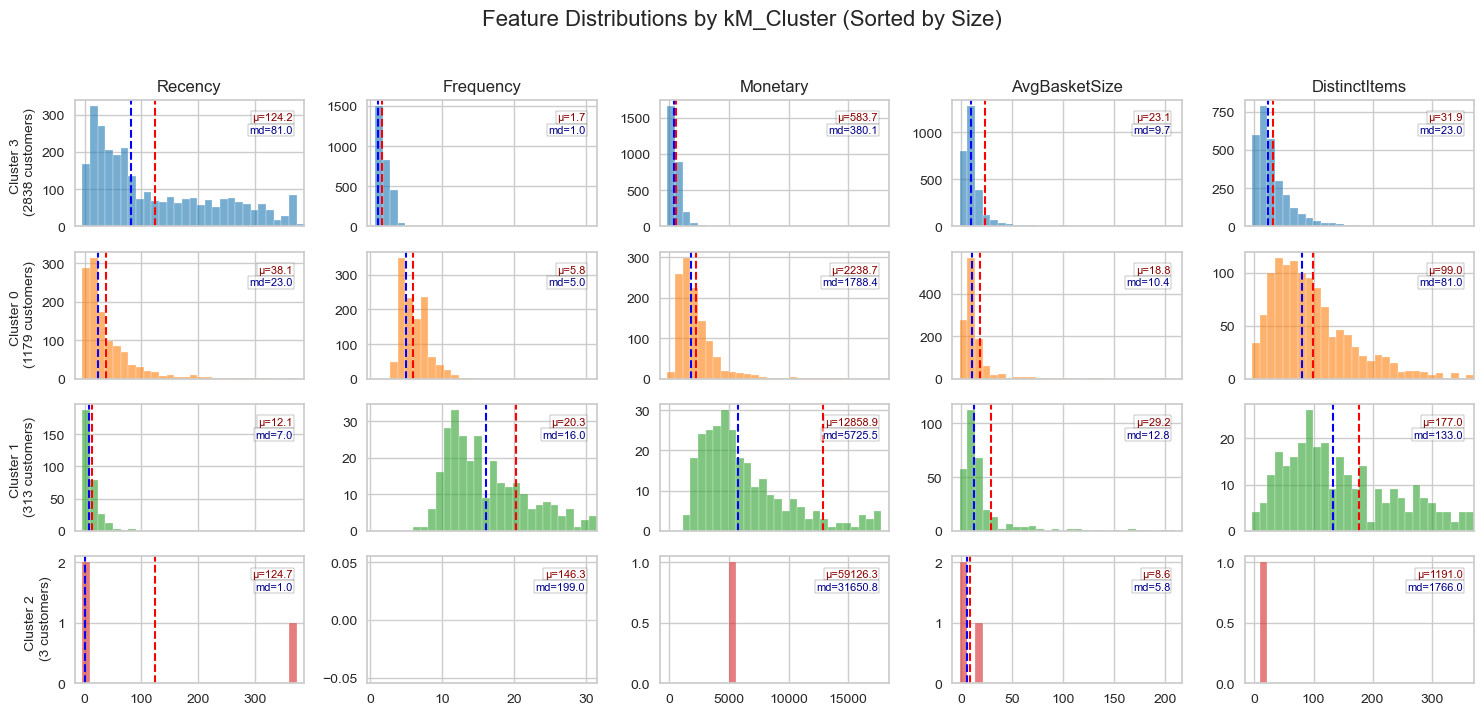

In [44]:
print("\nKMeans Cluster Analysis:")
display(km_cluster_analysis.sort_values(by='Num_Customers', ascending=False))
plot_cluster_distributions('kM_Cluster', features_to_plot, customer_features, figsize=fs)

#### k-Means Insights

After applying K-means clustering, I've identified four distinct segments with the following key characteristics and implications:

#### Dormant Majority (Cluster 3 - 65.50%)
This segment represents the largest portion of our customer base but shows minimal engagement. With an average of 124 days since their last purchase and only 1.66 purchases per customer, these are essentially one-time or occasional shoppers who haven't returned. While their basket size is decent (23.06 items), their limited purchase frequency results in a moderate total spend of $583.74. Their purchase coverage of just 0.12 indicates they've explored very little of our product range, suggesting either narrow interest or insufficient exposure to our full catalog.

The concerning aspect is that over 90% of these customers are from our primary UK market, meaning we're failing to retain a significant portion of our core demographic. The size of this segment (2,838 customers) presents both a challenge and an opportunity - these customers have already converted once but need compelling reasons to return.

#### Occasional Spenders (Cluster 0 - 27.21%)

This segment demonstrates higher engagement than the dormant majority, with more recent purchases (38 days) and better frequency (5.85 purchases). Their total monetary value is substantially higher at $2,238.66, indicating good spending power despite slightly smaller basket sizes (18.82 items) and lower average basket value ($27.15) compared to Cluster 3.

What's notable is their improved purchase coverage (0.36) and exploration of a wider range of products (98.96 distinct items), suggesting these customers are more adventurous in their shopping habits. These 1,179 customers represent our "middle class" - not our highest-value customers but showing potential for increased frequency and spend with the right incentives.

#### VIP Customers (Cluster 1 - 7.22%)

Though comprising only 7.22% of our customer base (313 customers), this segment delivers exceptional value. Their recency metric of just 12 days indicates active engagement, while their high frequency (20.27 purchases) demonstrates strong loyalty. Their monetary value is remarkable at $12,858.93 per customer - nearly 6 times that of our occasional spenders and 22 times our dormant segment.

These customers not only purchase more frequently but also spend more each time, with the largest basket size (29.19 items) and highest basket value ($49.40). Their purchase coverage of 0.78 and exploration of 177 distinct items shows they engage deeply with our product range. Like our other major segments, these are predominantly UK customers (90.10%), suggesting our core market is where we've managed to develop our strongest customer relationships.

#### High-Volume Anomalies (Cluster 2 - 0.07%)

This tiny segment of just 3 customers displays highly unusual purchasing patterns that set them apart from our typical customer base. Despite not having purchased recently (124.67 days), they show an extraordinary purchase frequency (146.33 purchases) and the highest monetary value by far ($59,126.27).

Their purchasing pattern is distinct: small baskets (8.56 items) with the lowest basket value ($16.70), but an incredibly wide range of products (1,191 distinct items) and good coverage (0.69). This pattern suggests these might be business customers, resellers, or wholesale accounts rather than individual consumers. They're also less UK-concentrated (66.67%) than our other segments, possibly indicating international business relationships or - despite our data cleaning, errors.

#### Cross-Segment Observations

The data reveals a clear value pyramid in the customer base:
- A small VIP segment (7.22%) delivering exceptional value through frequent, high-value purchases
- A moderate middle segment (27.21%) with good potential but inconsistent engagement
- A large dormant segment (65.50%) representing significant untapped potential if they could be reactivated
- A micro-segment of anomalous high-volume customers (0.07%) that operates on an entirely different scale

The stark differences in purchase recency, frequency, and product exploration between segments suggest that customer journey mapping could reveal critical drop-off points where we're losing potential VIPs to the dormant category.

### Hierarchical Clustering interpretation


Hierarchical Cluster Analysis:


,Recency,Frequency,Monetary,AvgBasketSize,AvgBasketValue,DistinctItems,PurchaseConsistency,PurchaseCoverage,IsUK,Num_Customers,Pct_Customers
Cluster,,,,,,,,,,,
2,120.98,1.80,660.70,24.38,40.78,36.62,1.10,0.12,90.73,2935,67.74
1,39.81,5.77,2256.83,15.00,24.03,93.02,1.27,0.35,89.71,1050,24.23
3,12.67,20.27,12057.76,27.29,47.25,176.01,1.96,0.76,89.05,347,8.01
4,372.00,34.00,5391.21,5.84,18.15,21.00,34.00,0.08,100.00,1,0.02



Hierarchical_Cluster has 4 clusters (sorted by size)


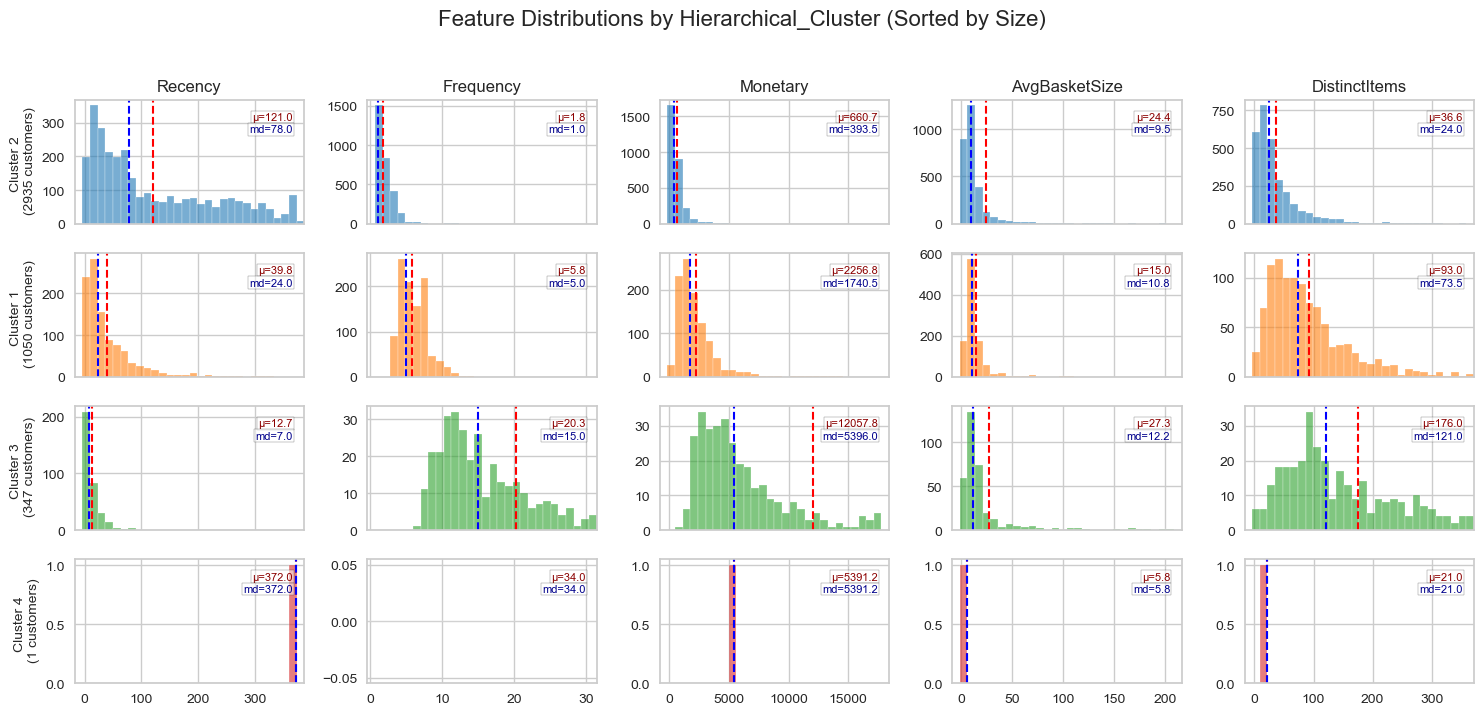

In [45]:
print("\nHierarchical Cluster Analysis:")
display(hierarchical_cluster_profile.sort_values(by='Num_Customers', ascending=False))
plot_cluster_distributions('Hierarchical_Cluster', features_to_plot, customer_features, figsize=fs)

#### Hierarchical Clustering - Comparison to k-Means

After applying hierarchical clustering to our customer dataset, I've identified four segments that show notable similarities and differences compared to our previous K-means clustering results:

#### Dormant Majority (Cluster 2 - 67.74%)

This segment closely resembles the "Dormant Majority" from our K-means analysis (previously Cluster 3), with similar characteristics. At 67.74% of customers (2,935), it represents an even slightly larger portion of our customer base. The metrics are remarkably consistent: high recency (120.98 days vs. 124.22 in K-means), low frequency (1.80 vs. 1.66), and moderate monetary value ($660.70 vs. $583.74). Basket size (24.38 items), basket value ($40.78), and purchase coverage (0.12) are also nearly identical to our previous findings.

This consistency across clustering methods reinforces our understanding that approximately two-thirds of our customers are relatively disengaged, having made few purchases and not returned recently.

#### Occasional Spenders (Cluster 1 - 24.23%)

This segment aligns with our previous "Occasional Spenders" (formerly Cluster 0), though representing a slightly smaller proportion (24.23% vs. 27.21% in K-means). The metrics remain consistent: moderate recency (39.81 days vs. 38.13), occasional purchasing frequency (5.77 vs. 5.85), and similar monetary value ($2,256.83 vs. $2,238.66).

The basket characteristics show minor variations, with a smaller average basket size (15.00 vs. 18.82) but comparable basket value ($24.03 vs. $27.15). Purchase coverage (0.35 vs. 0.36) and distinct items purchased (93.02 vs. 98.96) remain similar, confirming this as our "middle class" customer segment.

#### VIP Customers (Cluster 3 - 8.01%)

Our VIP segment shows consistency across both clustering methods, though hierarchical clustering assigned slightly more customers to this group (8.01% vs. 7.22% in K-means). The key metrics remain strongly aligned: recent purchases (12.67 days vs. 12.06), high frequency (20.27 identical in both), and substantial spending, though with a slightly lower monetary value in hierarchical clustering ($12,057.76 vs. $12,858.93).

Basket metrics are comparable with average size of 27.29 items (vs. 29.19) and basket value of $47.25 (vs. $49.40). Product exploration metrics remain high with 176.01 distinct items (vs. 177.01) and purchase coverage of 0.76 (vs. 0.78). This consistency confirms the presence of a small but valuable customer segment.

#### Outlier (Cluster 4 - 0.02%)

The hierarchical clustering identified a single customer outlier (0.02%) compared to the three anomalous customers (0.07%) in K-means. This customer shows even more extreme behavior: extremely high recency (372 days vs. 124.67), significant but lower frequency (34 purchases vs. 146.33), and a more moderate (though still high) monetary value ($5,391.21 vs. $59,126.27). The fact that the other two outliers in the k-Means clustering had significantly higher monetary values might explain the discrepancies we see in the inter-cluster means we've seen above.

### DBSCAN Interpretation


DBSCAN Cluster Analysis:


,Recency,Frequency,Monetary,AvgBasketSize,AvgBasketValue,DistinctItems,PurchaseConsistency,PurchaseCoverage,IsUK,Num_Customers,Pct_Customers
Cluster,,,,,,,,,,,
0,94.12,3.61,1304.56,16.06,26.25,58.36,1.16,0.22,90.38,4191,96.72
-1,47.90,23.72,22087.54,214.40,373.33,157.34,3.09,0.54,89.78,137,3.16
1,128.80,4.00,973.87,20.42,32.96,23.80,4.00,0.08,80.00,5,0.12



DBSCAN_Cluster has 3 clusters (sorted by size)


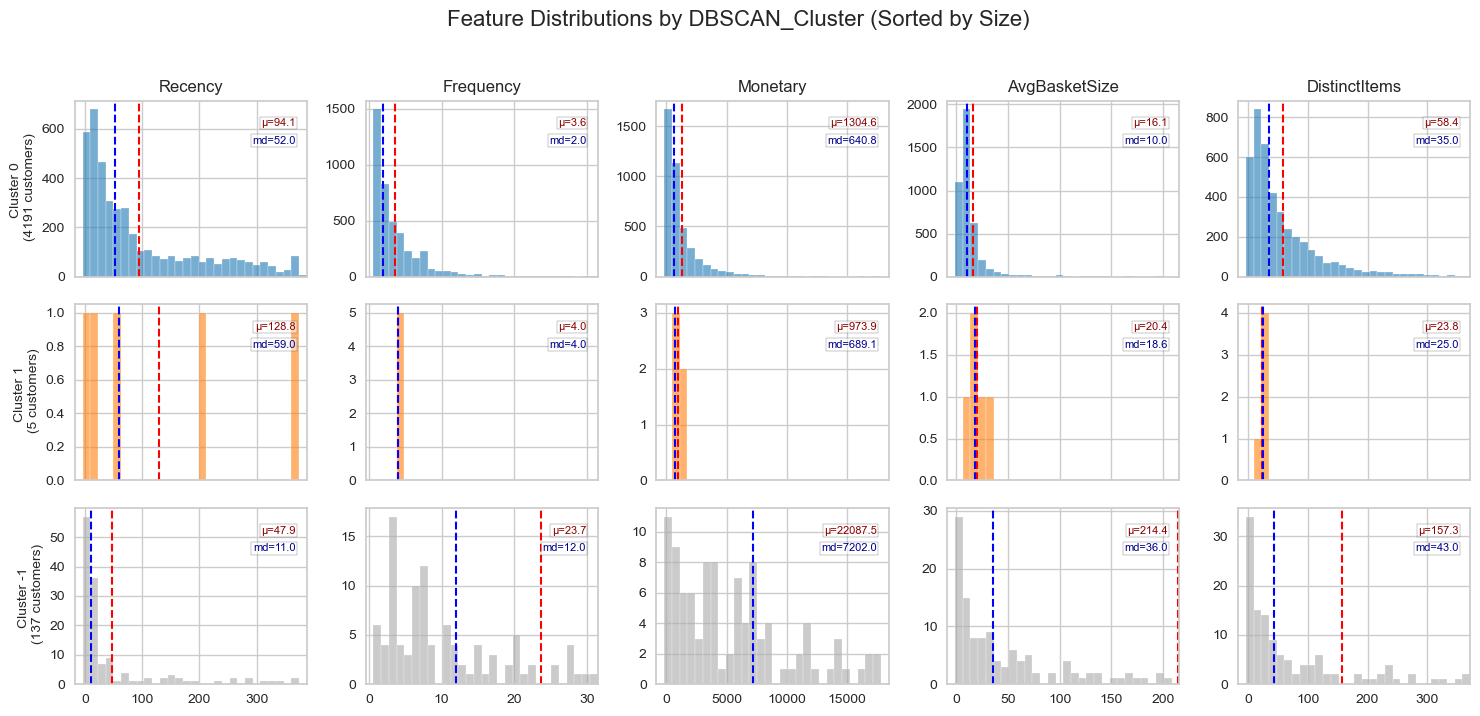

In [46]:
print("\nDBSCAN Cluster Analysis:")
display(dbscan_cluster_profile.sort_values(by='Num_Customers', ascending=False))
plot_cluster_distributions('DBSCAN_Cluster', features_to_plot, customer_features, figsize=fs)

#### DBSCAN Analysis Limitations

After examining the DBSCAN clustering results, it's seems like DBSCAN struggles to identify meaningful clusters from our dataset, which might be attributed to the slightly increased and still skewed feature distribution across our customer variables.

The algorithm has effectively:
- Placed 96.72% of customers (4,191) into a single cluster (Cluster 0)
- Isolated just 5 customers (0.12%) into a standalone cluster (Cluster 1)
- Discarded 137 customers (3.16%) as a noise (Cluster -1)

Despite our efforts to optimize DBSCAN through parameter tuning with various `eps` and `min_samples` values, the algorithm consistently fails to discover the nuanced customer segments that both K-means and hierarchical clustering methods successfully identified.

The primary issue appears to be DBSCAN's density-based approach, which struggles with:
1. The high-dimensional nature of our RFM+ dataset
2. The inherent skewness in customer behavior metrics
3. The lack of clear density-based boundaries between different customer types

While DBSCAN excels at identifying clusters of arbitrary shapes and detecting outliers in many contexts, our customer behavior data appears to be better suited to distance-based clustering approaches like K-means and hierarchical clustering, which provided more actionable and interpretable segments.

Based on these limitations, we will discard the DBSCAN results for further analysis and business interpretation, focusing instead on the more meaningful segmentation provided by the alternative clustering methods.

### Confusion Matrix k-Means vs. Hierarchical

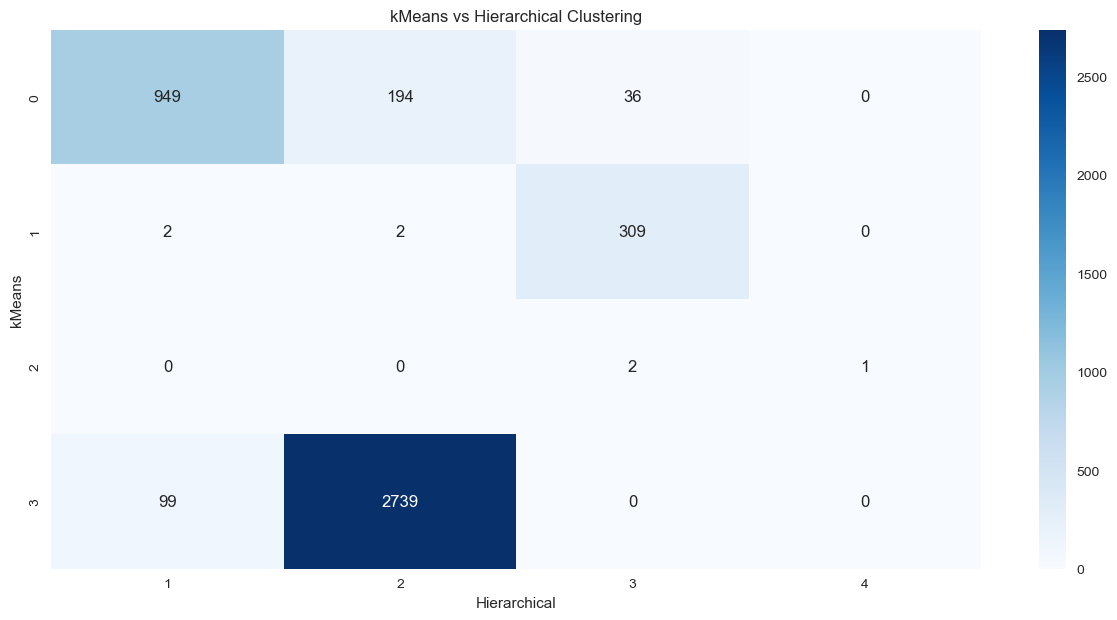

In [47]:
plt.figure(figsize=fs)
plt.title('kMeans vs Hierarchical Clustering')

cross_tab_kmeans = pd.crosstab(
    customer_features['kM_Cluster'], 
    customer_features['Hierarchical_Cluster'],
    rownames=['kMeans'], 
    colnames=['Hierarchical'],
)

sns.heatmap(cross_tab_kmeans, annot=True, fmt='d', cmap='Blues')
plt.show()

### Main takeaways from comparing k-Means and Hierarchical clustering results:

1. **Robust Segmentation**: The remarkable consistency between K-means and hierarchical clustering validates our segmentation approach. Both methods identified similar customer groups with consistent behavioral patterns, increasing our confidence in these segments as a foundation for strategic planning.

2. **Segment Proportions**: Hierarchical clustering assigned slightly more customers to the dormant segment (67.74% vs. 65.50%) and fewer to the middle segment (24.23% vs. 27.21%), suggesting some borderline customers may display characteristics that could place them in either group.

3. **Different Outlier Detection**: The most significant difference appears in the outlier segment, where hierarchical clustering identified a single customer with very different behavioral patterns than the three anomalies found in K-means. This suggests these methods have different sensitivities to unusual purchasing patterns.

4. **Value Distribution**: The distribution of value across segments remains consistent, with a small percentage of customers (8.01% in hierarchical clustering) accounting for disproportionately high spending, frequency, and engagement, while the majority (67.74%) remain relatively disengaged with minimal spending.

# 7. Creating Customer Profiles

Based on the cluster validation and comparison in 6) we can be quite confident in our segment analysis and proceed to create customer label. 
In a first step, we add the labels to the dataframe:

In [48]:
segment_labels = {
    3: "Dormant Majority",     # K-means cluster 3 (corresponds to Hierarchical cluster 2)
    0: "Occasional Spenders",  # K-means cluster 0 (corresponds to Hierarchical cluster 1)
    1: "VIP Customers",        # K-means cluster 1 (corresponds to Hierarchical cluster 3)
    2: "High-Value Anomalies"  # K-means cluster 2 (roughly corresponds to Hierarchical cluster 4, though hierarchical only found 1 customer here)
}

customer_features['Customer_Segment'] = customer_features['kM_Cluster'].map(segment_labels)

km_cluster_analysis['Segment'] = km_cluster_analysis.index.map(segment_labels)

customer_features.groupby('Customer_Segment').agg(info_dict).rename(columns={'CustomerID': 'Num_Customers'}).sort_values(by='Num_Customers', ascending=False)

,Recency,Frequency,Monetary,AvgBasketSize,AvgBasketValue,DistinctItems,PurchaseConsistency,PurchaseCoverage,IsUK,Num_Customers
Customer_Segment,,,,,,,,,,
Dormant Majority,124.224101,1.664553,583.741293,23.057477,40.106745,31.920719,1.087679,0.118095,0.904510,2838
Occasional Spenders,38.131467,5.848176,2238.658388,18.815254,27.149776,98.964377,1.285960,0.357604,0.902460,1179
VIP Customers,12.060703,20.271565,12858.931597,29.188670,49.399752,177.012780,1.972143,0.775621,0.900958,313
High-Value Anomalies,124.666667,146.333333,59126.273333,8.562876,16.703329,1191.000000,21.717949,0.692308,0.666667,3


## Plotting customer profiles (monetary vs. frequency)

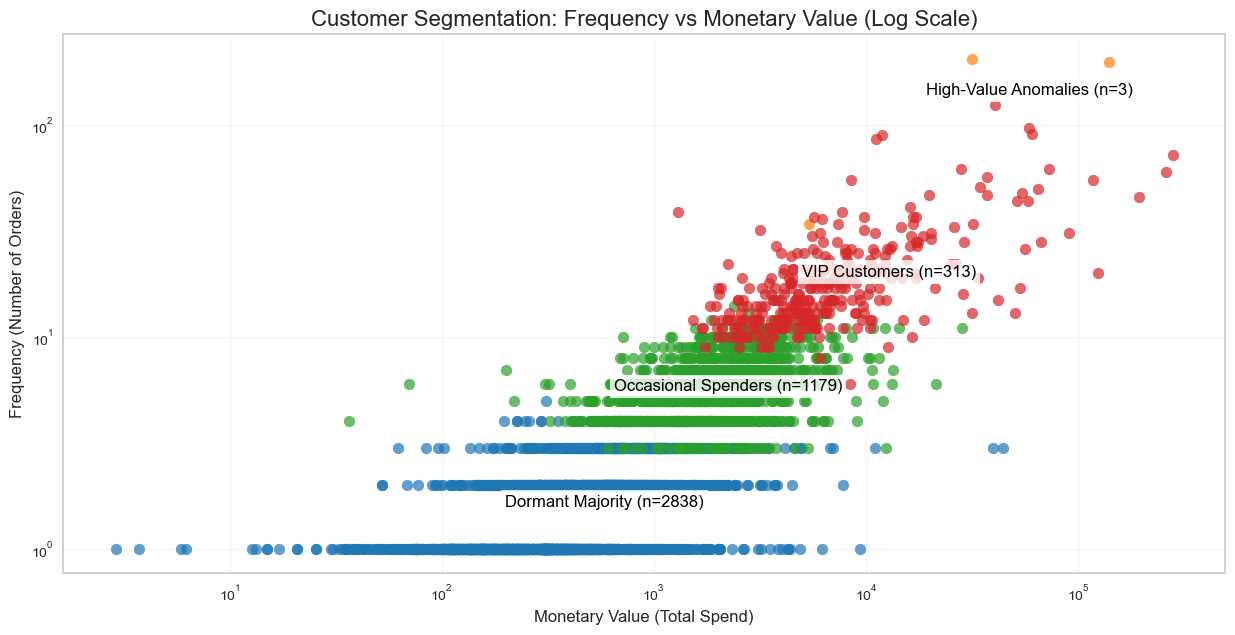

In [49]:
plt.figure(figsize=fs)

cmap = plt.get_cmap("tab10")

segment_to_numeric = {segment: idx for idx, segment in enumerate(sorted(customer_features['Customer_Segment'].unique()))}

for segment in sorted(customer_features['Customer_Segment'].unique()):
    cluster_data = customer_features[customer_features['Customer_Segment'] == segment]
    
    avg_monetary = cluster_data['Monetary'].mean()
    avg_frequency = cluster_data['Frequency'].mean()
    
    plt.scatter(
        cluster_data['Monetary'], 
        cluster_data['Frequency'],
        alpha=0.7,
        s=60,  # Slightly larger points
        color=cmap(segment_to_numeric[segment]),
        label=None  # No label in legend
    )
    
    plt.annotate(
        f"{segment} (n={len(cluster_data)})",
        (avg_monetary, avg_frequency),
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3),
        ha='center',
        va='center'
    )

# Set log scale for axes
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Monetary Value (Total Spend)', fontsize=12)
plt.ylabel('Frequency (Number of Orders)', fontsize=12)
plt.title('Customer Segmentation: Frequency vs Monetary Value (Log Scale)', fontsize=16)
plt.grid(True, alpha=0.2) 

plt.show()

## Analyzing top products across segments

In [50]:
def plot_top_products_by_segment(df, customer_features, n_products=3):
    """
    Plot the top N products for each customer segment side by side.
    
    Parameters:
    df (DataFrame): The transaction data
    customer_features (DataFrame): DataFrame with CustomerID and Customer_Segment
    n_products (int): Number of top products to display per segment
    """
    # Create segment product counts
    segment_product_counts = df.merge(
        customer_features[['CustomerID', 'Customer_Segment']], 
        on='CustomerID',
        how='inner'
    ).groupby(['Customer_Segment', 'StockCode']).agg({
        'Quantity': 'sum',
        'Description': 'first'  # Keep product description
    }).reset_index()
    
    # Handle missing descriptions
    segment_product_counts['Description'] = segment_product_counts['Description'].fillna('No Description Available')

    # Order segments by the number of customers
    segment_counts = customer_features['Customer_Segment'].value_counts()
    segments = segment_counts.index.tolist()  # Ordered by customer count

    # Find top N products per segment
    top_products_data = []
    for segment in segments:
        segment_data = segment_product_counts[segment_product_counts['Customer_Segment'] == segment]
        top_n = segment_data.nlargest(n_products, 'Quantity')
        
        total_segment_sales = segment_data['Quantity'].sum()  
        
        for _, row in top_n.iterrows():
            top_products_data.append({
                'Segment': segment,
                'StockCode': row['StockCode'],
                'Description': row['Description'],
                'Quantity': row['Quantity'],
                'Percentage': (row['Quantity'] / total_segment_sales) * 100  
            })

    top_products_df = pd.DataFrame(top_products_data)

    # Create plot
    fig, axes = plt.subplots(1, len(segments), figsize=(5 * len(segments), 6), sharey=True)
    
    # Handle single segment case
    if len(segments) == 1:
        axes = [axes]
        
    for i, segment in enumerate(segments):
        segment_top = top_products_df[top_products_df['Segment'] == segment].copy()  

        # Truncate long descriptions and add stock code
        segment_top['Product'] = segment_top['Description'].str.slice(0, 18) + "\n(#" + segment_top['StockCode'].astype(str) + ")"
        
        # Sort by quantity (ascending for correct bar order)
        segment_top = segment_top.sort_values('Quantity', ascending=True)
        
        # Create horizontal bar chart
        sns.barplot(
            x='Quantity', 
            y='Product',
            hue='Product', 
            data=segment_top,
            ax=axes[i],
            palette='viridis',
            legend=False  
        )

        # Formatting
        axes[i].set_title(f'{segment} (n={segment_counts[segment]})', fontsize=12)
        axes[i].set_xlabel('Quantity Sold', fontsize=10)
        
        if i == 0:
            axes[i].set_ylabel('Product', fontsize=12)
        else:
            axes[i].set_ylabel('')
            
    plt.suptitle(f'Top {n_products} Products by Customer Segment', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Return the data for display in tables
    return top_products_df

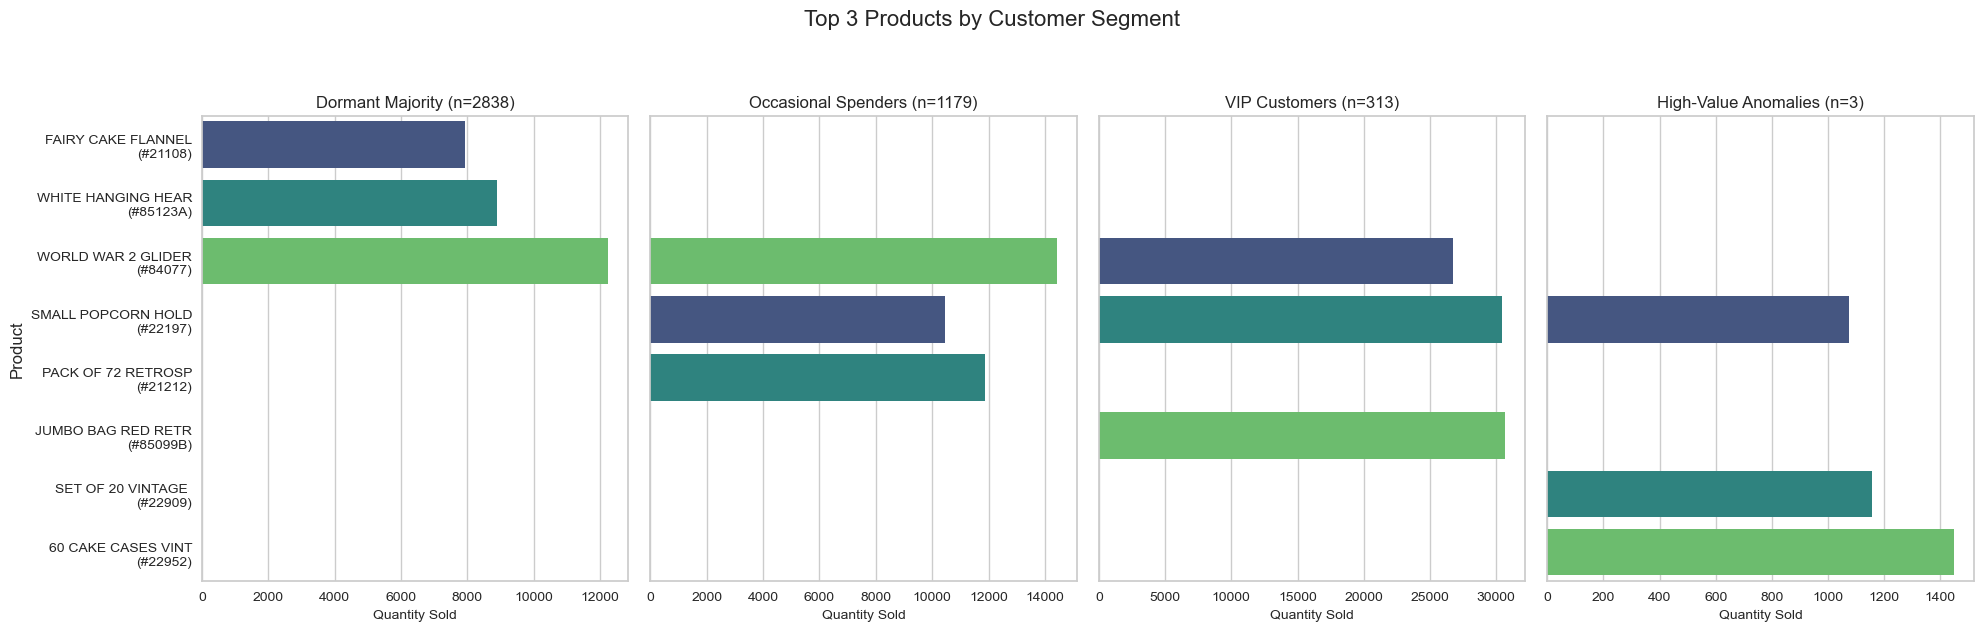

In [51]:
top_products_df = plot_top_products_by_segment(df, customer_features, n_products=3)

In [52]:
# Display table for each segment
for segment in customer_features['Customer_Segment'].unique():
    segment_data = top_products_df[top_products_df['Segment'] == segment].sort_values('Quantity', ascending=False).reset_index(drop=True)
    
    print(f"\n--- Top 3 Products: {segment} ---")
    display(segment_data[['StockCode', 'Description', 'Quantity', 'Percentage']])


--- Top 3 Products: Occasional Spenders ---


,StockCode,Description,Quantity,Percentage
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,14413,0.893624
1,21212,PACK OF 72 RETROSPOT CAKE CASES,11855,0.735025
2,22197,SMALL POPCORN HOLDER,10464,0.648781



--- Top 3 Products: Dormant Majority ---


,StockCode,Description,Quantity,Percentage
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,12245,1.245656
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,8893,0.904665
2,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,7946,0.808329



--- Top 3 Products: VIP Customers ---


,StockCode,Description,Quantity,Percentage
0,85099B,JUMBO BAG RED RETROSPOT,30676,1.343235
1,22197,SMALL POPCORN HOLDER,30453,1.333470
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,26749,1.171280



--- Top 3 Products: High-Value Anomalies ---


,StockCode,Description,Quantity,Percentage
0,22952,60 CAKE CASES VINTAGE CHRISTMAS,1448,1.352993
1,22909,SET OF 20 VINTAGE CHRISTMAS NAPKINS,1157,1.081086
2,22197,SMALL POPCORN HOLDER,1075,1.004466


### Product Insights Summary

From the analysis of top products across different customer segments, we can gather some important insights that can inform our marketing strategies.

For the **Dormant Majority** segment, the top products include the "WORLD WAR 2 GLIDERS ASSTD DESIGNS," which has the highest quantity and a relatively small percentage (1.25%) of the overall sales. This indicates that while these products are popular in this segment, their overall sales are low, suggesting potential for growth with targeted campaigns. Other products like the "WHITE HANGING HEART T-LIGHT HOLDER" and "FAIRY CAKE FLANNEL ASSORTED COLOUR" show moderate interest but also low conversion, meaning we could invest in re-engagement strategies to boost their appeal.

In the **Occasional Spenders** segment, we see a similar trend with the "WORLD WAR 2 GLIDERS ASSTD DESIGNS" topping the list again, followed by "PACK OF 72 RETROSPOT CAKE CASES." These products have a slightly better share of sales compared to the dormant majority, suggesting that these customers make occasional but larger purchases. Marketing efforts in this segment could focus on encouraging repeat purchases of these popular items, perhaps through time-limited offers or bundling them with complementary products.

The **VIP Customers** segment stands out, with "JUMBO BAG RED RETROSPOT" leading, making up 1.34% of total sales. The "SMALL POPCORN HOLDER" and "WORLD WAR 2 GLIDERS ASSTD DESIGNS" follow closely. These customers have a much larger share of sales compared to other segments, highlighting their high value. We can target these customers with premium offerings, exclusive deals, or loyalty programs to increase retention and maximize their lifetime value.

Finally, the **High-Value Anomalies** segment shows products like the "60 CAKE CASES VINTAGE CHRISTMAS" and "SET OF 20 VINTAGE CHRISTMAS NAPKINS" performing well despite low total quantities. This suggests a niche but high-potential market for seasonal or unique items. Targeting this segment with personalized promotions or seasonal campaigns could increase visibility and conversions, tapping into their specific interest.

In summary, the data highlights different behaviors across segments. Dormant customers need re-engagement, occasional spenders could benefit from reminders and promotions, VIPs require personalized offers to maintain loyalty, and anomalies might be best approached with targeted seasonal or exclusive offers.

,Customer Segment,Number of Customers,Total Revenue,Customer %,Revenue %,Avg Revenue per Customer
3,VIP Customers,313,4024845.59,7.22,47.36,12858.93
2,Occasional Spenders,1179,2639378.24,27.21,31.06,2238.66
0,Dormant Majority,2838,1656657.79,65.50,19.49,583.74
1,High-Value Anomalies,3,177378.82,0.07,2.09,59126.27


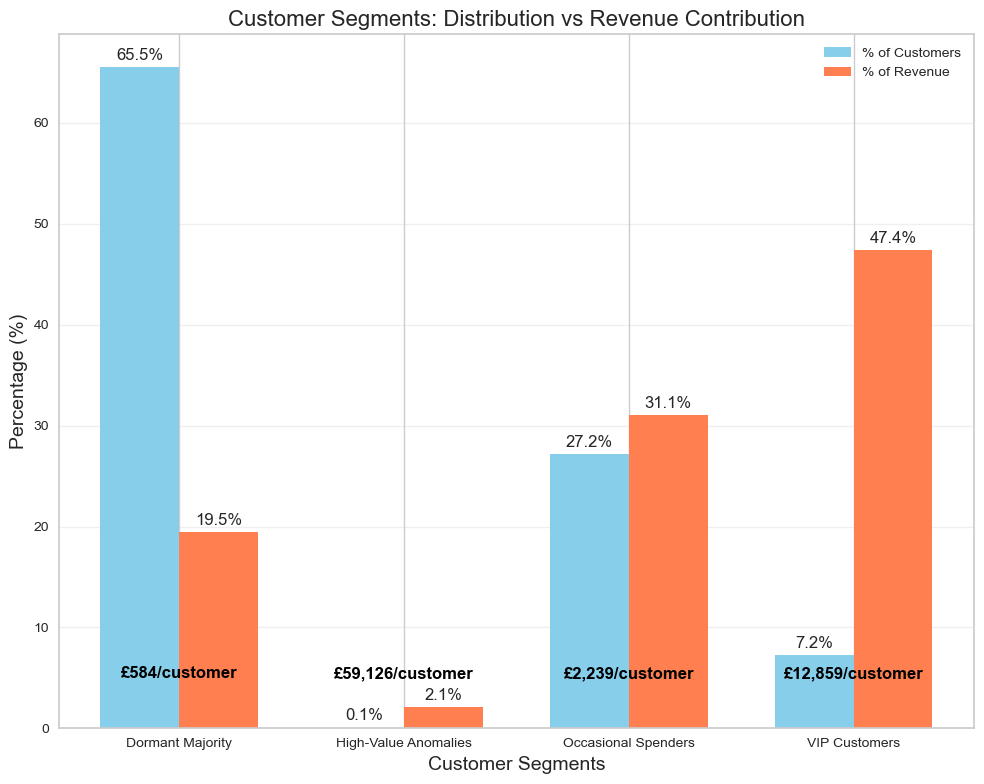


--- Pareto Analysis (80/20 Rule) ---
Top 7.2% of customers ('VIP Customers' segment) generate 47.4% of total revenue
Approximately 34.4% of customers generate 80% of revenue


In [53]:
# Calculate revenue contribution by segment
revenue_by_segment = customer_features.groupby('Customer_Segment').agg({
    'CustomerID': 'count',  # Number of customers
    'Monetary': 'sum'      # Total revenue
}).reset_index()

revenue_by_segment['Pct_Customers'] = (revenue_by_segment['CustomerID'] / revenue_by_segment['CustomerID'].sum() * 100).round(2)
revenue_by_segment['Pct_Revenue'] = (revenue_by_segment['Monetary'] / revenue_by_segment['Monetary'].sum() * 100).round(2)
revenue_by_segment['Revenue_per_Customer'] = (revenue_by_segment['Monetary'] / revenue_by_segment['CustomerID']).round(2)

revenue_by_segment.columns = ['Customer Segment', 'Number of Customers', 'Total Revenue', 
                             'Customer %', 'Revenue %', 'Avg Revenue per Customer']

display(revenue_by_segment.sort_values('Total Revenue', ascending=False))

fig, ax = plt.subplots(figsize=fs_square)

x = np.arange(len(revenue_by_segment))
width = 0.35

bars1 = ax.bar(x - width/2, revenue_by_segment['Customer %'], width, label='% of Customers', color='skyblue')
bars2 = ax.bar(x + width/2, revenue_by_segment['Revenue %'], width, label='% of Revenue', color='coral')

# Add labels and titles
ax.set_title('Customer Segments: Distribution vs Revenue Contribution', fontsize=16)
ax.set_xlabel('Customer Segments', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(revenue_by_segment['Customer Segment'])

# Add data labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', 
                    va='bottom')

add_labels(bars1)
add_labels(bars2)

# Add value per customer as text
for i, segment in enumerate(revenue_by_segment['Customer Segment']):
    avg_revenue = revenue_by_segment.loc[revenue_by_segment['Customer Segment'] == segment, 'Avg Revenue per Customer'].values[0]
    ax.text(i, 5, f'£{avg_revenue:,.0f}/customer', 
            ha='center', color='black', fontweight='bold')

ax.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate Pareto metrics (80/20 rule analysis)
revenue_by_segment_sorted = revenue_by_segment.sort_values('Total Revenue', ascending=False)
revenue_by_segment_sorted['Cumulative Revenue %'] = revenue_by_segment_sorted['Revenue %'].cumsum()

print("\n--- Pareto Analysis (80/20 Rule) ---")
print(f"Top {revenue_by_segment_sorted['Customer %'].iloc[0]:.1f}% of customers ('{revenue_by_segment_sorted['Customer Segment'].iloc[0]}' segment) generate {revenue_by_segment_sorted['Revenue %'].iloc[0]:.1f}% of total revenue")

# Find how many segments needed to reach 80% of revenue
segments_for_80pct = revenue_by_segment_sorted[revenue_by_segment_sorted['Cumulative Revenue %'] <= 80]['Customer %'].sum()
print(f"Approximately {segments_for_80pct:.1f}% of customers generate 80% of revenue")